In [1]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**🔹 Load in the merged datasets from the preprocessing notebook**

In [2]:
df_COST = pd.read_csv('concatCOST_df.csv')
df_PENALTY = pd.read_csv('concatPENALTY_df.csv')
df_PROVIDER = pd.read_csv('concatPROVIDER_df.csv')

<ipython-input-2-7d0825736e92>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_COST = pd.read_csv('concatCOST_df.csv')
<ipython-input-2-7d0825736e92>:3: DtypeWarning: Columns (17,22,24,26,28,30,31,32,63,64,65,66,67,68,69,70,71,80,81,82,83,84,85,86,87,88,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_PROVIDER = pd.read_csv('concatPROVIDER_df.csv')


## **◼ Synchronize column names across the datasets (PROVNUM, YEAR)**

**🔹 Right now, the only common column names between the three datasets is the Year attribute.**

In [3]:
columns_COST = df_COST.columns
columns_PENALTY = df_PENALTY.columns
columns_PROVIDER = df_PROVIDER.columns


# Finding common attributes
common_attributes = set(columns_COST) & set(columns_PENALTY) & set(columns_PROVIDER)

# Print common attributes
print("Common attributes among all datasets:")
print(common_attributes)

Common attributes among all datasets:
{'Year'}


**🔹 We found that Provider_CNN in the Cost Report data is equivalent to the Provider Number (PROVNUM) in the Penalty and Provider Info data sets**

In [4]:
column_mapping = {
    'Provider_CCN': 'PROVNUM'}

# Rename the columns
df_COST.rename(columns=column_mapping, inplace=True)

**🔹 Below, we transform all column names to UPPERCASE for consistency**

In [5]:
df_COST.columns = df_COST.columns.str.upper()
df_PENALTY.columns = df_PENALTY.columns.str.upper()
df_PROVIDER.columns = df_PROVIDER.columns.str.upper()

**🔹 Check that the PROVNUM has the same data type across the datasets.**

Then change PROVNUM to a string data type for consistency

In [6]:
pnum1 = df_COST['PROVNUM'].dtype
pnum2 = df_PENALTY['PROVNUM'].dtype
pnum3 = df_PROVIDER['PROVNUM'].dtype

print("Data type of df_COST'PROVNUM':", pnum1)
print("Data type of df_PENALTY'PROVNUM':", pnum2)
print("Data type of df_PROVIDER'PROVNUM':", pnum3)

Data type of df_COST'PROVNUM': int64
Data type of df_PENALTY'PROVNUM': object
Data type of df_PROVIDER'PROVNUM': object


In [7]:
df_COST['PROVNUM'] = df_COST['PROVNUM'].astype('string')
df_PENALTY['PROVNUM'] = df_PENALTY['PROVNUM'].astype('string')
df_PROVIDER['PROVNUM'] = df_PROVIDER['PROVNUM'].astype('string')

## **◼ Dealing with Null Values and Outliers for Each Dataset**

### **◼ Additional Cleaning of df_COST**

**🔹 Check the amount of rows and columns before cleaning**

In [8]:
amt_rows = df_COST.shape[0]
amt_columns = df_COST.shape[1]
print("df_COST amount of rows:", amt_rows)
print("df_COST amount of columns:", amt_columns)

df_COST amount of rows: 106269
df_COST amount of columns: 137


In [9]:
#CHECK FOR NA IN EACH DATASET - df_COST
df_COST.isna().sum()

RPT_REC_NUM                                                            0
PROVNUM                                                                0
FACILITY_NAME                                                          0
STREET_ADDRESS                                                         9
CITY                                                                   0
                                                                   ...  
LESS_CONTRACTUAL_ALLOWANCE_AND_DISCOUNTS_ON_PATIENTS'_ACCOUNTS     78549
NET_INCOME_FROM_SERVICE_TO_PATIENTS                                76675
TOTAL_OTHER_INCOME                                                 77214
NURSING_AND_ALLIED_HEALTH_EDUCATION_ACTIVITIES                    106261
ALLOWABLE_BAD_DEBTS                                                84201
Length: 137, dtype: int64

**🔹 The above chunk of code shows us that there are quite a few variables in the df_COST dataset that are majority null variables. We should drop these columns as they do not add value to the analysis.**

In [10]:
# Check for percent of null values in the Net Income variable (since this will be our dependent variable for the analysis)
nullNetIncome = (df_COST['NET_INCOME'].isnull().sum()/len(df_COST))*100
print(nullNetIncome)

2.2207793429880773


**🔹 Before cleaning, the NET_INCOME variable has about 2% null values.**

In [11]:
# Check to see which variables in df_COST have more than 50% null values
nullPercent = (df_COST.isnull().sum() / len(df_COST)) * 100
highNullPercent = nullPercent[nullPercent >50]
sort_highNullPercent = highNullPercent.sort_values(ascending=False)
print(sort_highNullPercent)

NURSING_AND_ALLIED_HEALTH_EDUCATION_ACTIVITIES    99.992472
NF_ADMISSIONS_TITLE_V                             99.989649
NF_AVERAGE_LENGTH_OF_STAY_TITLE_V                 99.989649
NF_DISCHARGES_TITLE_V                             99.989649
NF_DAYS_TITLE_V                                   99.989649
                                                    ...    
NET_INCOME_FROM_SERVICE_TO_PATIENTS               72.151803
TOTAL_SALARIES_(ADJUSTED)                         72.150862
OVERHEAD_NON-SALARY_COSTS                         72.150862
BUILDINGS                                         59.515945
FIXED_EQUIPMENT                                   56.356981
Length: 64, dtype: float64


**🔹 This shows us that there are 64 columns in the dataset that have greater than 50% null values. We decided to drop these columns since they will not add value to the dataset's analysis**

In [12]:
#Get the names of the columns that are needed to drop
print(highNullPercent.index)

Index(['BUILDINGS', 'FIXED_EQUIPMENT', 'TOTAL_DAYS_TITLE_V',
       'TOTAL_DISCHARGES_TITLE_V', 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_V',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 'SNF_ADMISSIONS_TITLE_V',
       'SNF_DAYS_TITLE_V', 'SNF_NUMBER_OF_BEDS', 'SNF_BED_DAYS_AVAILABLE',
       'SNF_DISCHARGES_TITLE_V', 'NF_NUMBER_OF_BEDS', 'NF_BED_DAYS_AVAILABLE',
       'NF_DAYS_TITLE_V', 'NF_DAYS_TITLE_XIX', 'NF_DAYS_OTHER',
       'NF_DAYS_TOTAL', 'NF_DISCHARGES_TITLE_V', 'NF_DISCHARGES_TITLE_XIX',
       'NF_DISCHARGES_TITLE_OTHER', 'NF_DISCHARGES_TOTAL',
       'NF_AVERAGE_LENGTH_OF_STAY_TITLE_V',
       'NF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'NF_AVERAGE_LENGTH_OF_STAY_TOTAL', 'NF_ADMISSIONS_TITLE_V',
       'NF_ADMISSIONS_TITLE_XIX', 'NF_ADMISSIONS_OTHER', 'NF_ADMISSIONS_TOTAL',
       'OVERHEAD_NON-SALARY_COSTS', 'TOTAL_CHARGES',
       'WAGE-RELATED_COSTS_(CORE)', 'TOTAL_SALARIES_(ADJUS

**🔹 Drop columns in df_COST that have > 50% null values.**

In [13]:
df_COST.rename(columns=lambda x: x.replace("LESS_CONTRACTUAL_ALLOWANCE_AND_DISCOUNTS_ON_PATIENTS'_ACCOUNTS", 'LESS_CONTRACTUAL_ALLOWANCE_AND_DISCOUNTS_ON_PATIENTS_ACCOUNTS'), inplace=True)
df_COST_dropna = df_COST.drop(labels = ['BUILDINGS','FIXED_EQUIPMENT', 'TOTAL_DAYS_TITLE_V','TOTAL_DISCHARGES_TITLE_V', 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_V',
                                    'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII','SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX','SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 'SNF_ADMISSIONS_TITLE_V',
                                    'SNF_DAYS_TITLE_V', 'SNF_NUMBER_OF_BEDS', 'SNF_BED_DAYS_AVAILABLE','SNF_DISCHARGES_TITLE_V', 'NF_NUMBER_OF_BEDS', 'NF_BED_DAYS_AVAILABLE',
                                    'NF_DAYS_TITLE_V', 'NF_DAYS_TITLE_XIX', 'NF_DAYS_OTHER','NF_DAYS_TOTAL', 'NF_DISCHARGES_TITLE_V', 'NF_DISCHARGES_TITLE_XIX',
                                    'NF_DISCHARGES_TITLE_OTHER', 'NF_DISCHARGES_TOTAL','NF_AVERAGE_LENGTH_OF_STAY_TITLE_V','NF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
                                    'NF_AVERAGE_LENGTH_OF_STAY_TOTAL', 'NF_ADMISSIONS_TITLE_V','NF_ADMISSIONS_TITLE_XIX', 'NF_ADMISSIONS_OTHER', 'NF_ADMISSIONS_TOTAL',
                                    'OVERHEAD_NON-SALARY_COSTS', 'TOTAL_CHARGES','WAGE-RELATED_COSTS_(CORE)', 'TOTAL_SALARIES_(ADJUSTED)','CONTRACT_LABOR', 'TEMPORARY_INVESTMENTS', 'NOTES_RECEIVABLE',
                                    'LESS:_ALLOWANCES_FOR_UNCOLLECTIBLE_NOTES_AND_ACCOUNTS_RECEIVABLE','INVENTORY', 'PREPAID_EXPENSES', 'OTHER_CURRENT_ASSETS',
                                    'TOTAL_CURRENT_ASSETS', 'LAND', 'LAND_IMPROVEMENTS','LEASEHOLD_IMPROVEMENTS', 'MINOR_EQUIPMENT_DEPRECIABLE', 'INVESTMENTS',
                                    'SALARIES,_WAGES,_AND_FEES_PAYABLE', 'LESS_CONTRACTUAL_ALLOWANCE_AND_DISCOUNTS_ON_PATIENTS_ACCOUNTS','PAYROLL_TAXES_PAYABLE','NOTES_AND_LOANS_PAYABLE_(SHORT_TERM)', 'DEFERRED_INCOME',
                                    'MORTGAGE_PAYABLE', 'NOTES_PAYABLE', 'UNSECURED_LOANS','OTHER_LONG_TERM_LIABILITIES', 'TOTAL_LONG_TERM_LIABILITIES',
                                    'TOTAL_LIABILITIES_AND_FUND_BALANCES','TOTAL_GENERAL_INPATIENT_CARE_SERVICES_REVENUE', 'OUTPATIENT_REVENUE',
                                    'NET_INCOME_FROM_SERVICE_TO_PATIENTS', 'TOTAL_OTHER_INCOME','NURSING_AND_ALLIED_HEALTH_EDUCATION_ACTIVITIES','ALLOWABLE_BAD_DEBTS'], axis=1)

**🔹 Verify that the remaining columns do not have more than 50% null values.**

In [14]:
nullPercent = (df_COST_dropna.isnull().sum() / len(df_COST_dropna)) * 100
sort_nullPercent = nullPercent.sort_values(ascending=False)
print(sort_nullPercent)

OTHER_ASSETS                       42.829988
SNF_AVERAGE_LENGTH_STAY_XIX        38.950211
SALARIES_WAGES_AND_FEES_PAYABLE    35.725376
LESS_DISCOUNTS_ON_PATIENTS         34.611222
MAJOR_MOVABLE_EQUIPMENT            31.325222
                                     ...    
ZIP_CODE                            0.000000
STATE_CODE                          0.000000
CITY                                0.000000
FACILITY_NAME                       0.000000
YEAR                                0.000000
Length: 70, dtype: float64


In [15]:
#Remaining column names in the df_COST dataset
print(df_COST_dropna.columns)

Index(['RPT_REC_NUM', 'PROVNUM', 'FACILITY_NAME', 'STREET_ADDRESS', 'CITY',
       'STATE_CODE', 'ZIP_CODE', 'COUNTY', 'MEDICARE_CBSA_NUMBER',
       'RURAL_VERSUS_URBAN', 'FISCAL_YEAR_BEGIN_DATE', 'FISCAL_YEAR_END_DATE',
       'TYPE_OF_CONTROL', 'ACCOUNTS_RECEIVABLE', 'ACCOUNTS_PAYABLE',
       'CASH_ON_HAND_AND_IN_BANKS', 'GENERAL_FUND_BALANCE', 'GROSS_REVENUE',
       'INPATIENT_PPS_AMOUNT', 'INPATIENT_REVENUE',
       'LESS_TOTAL_OPERATING_EXPENSE', 'LESS_DISCOUNTS_ON_PATIENTS',
       'MAJOR_MOVABLE_EQUIPMENT', 'NET_INCOME', 'NET_INCOME_FROM_PATIENTS',
       'NET_PATIENT_REVENUE', 'NUMBER_OF_BEDS', 'OTHER_ASSETS',
       'OTHER_CURRENT_LIABILITIES', 'OVERHEAD_NON_SALARY_COSTS',
       'SNF_ADMISSIONS_OTHER', 'SNF_ADMISSIONS_TITLE_XIX',
       'SNF_ADMISSIONS_TITLE_XVIII', 'SNF_ADMISSIONS_TOTAL',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOT', 'SNF_AVERAGE_LENGTH_STAY_XIX',
       'SNF_AVERAGE_LENGTH_STAY_XVIII', 'SNF_DAYS_OTHER', 'SNF_DAYS_TITLE_XIX',
       'SNF_DAYS_TITLE_XVIII', 'SN

**🔹 Next, we will handle outliers within NET_INCOME using z-score methodology.**

First, we'll visualize the current distribution of NET_INCOME with a box plot:

<Axes: xlabel='NET_INCOME'>

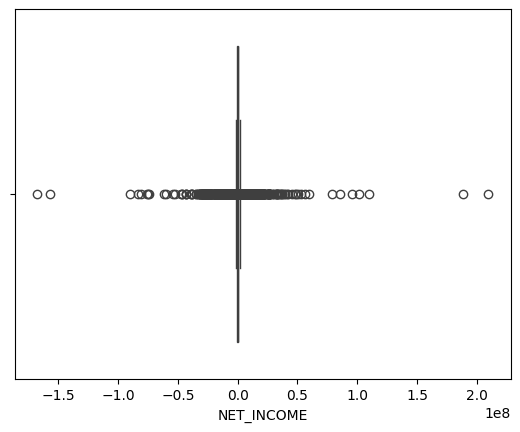

In [16]:
sns.boxplot(x=df_COST_dropna['NET_INCOME'])

In [17]:
# Calculate z-score for NET_INCOME column
zscoreCOST = (df_COST_dropna['NET_INCOME'] - df_COST_dropna['NET_INCOME'].mean())/ df_COST_dropna['NET_INCOME'].std()

# Set a threshold for the outliers
threshold = 3
outliers_zscoreCOST = df_COST_dropna[np.abs(zscoreCOST) > threshold]
print(outliers_zscoreCOST)

        RPT_REC_NUM PROVNUM                         FACILITY_NAME  \
373         1119821  495096       WESTMINSTER CANTERBURY RICHMOND   
514         1121366  345235                  TWIN LAKES COMMUNITY   
564         1121600  505371  FOUNTAINS AT PACIFIC REGENT-BELLEVUE   
699         1122230   35279      ACACIA HEALTH CENTER AT SAGEWOOD   
778         1122602  245621  PRESBYTERIAN HOMES - WAYZATA BAY-FOL   
...             ...     ...                                   ...   
106048      1364828  395780           FAIR ACRES GERIATRIC CENTER   
106159      1365458  205054          MAINEGENERAL REHAB GRAYBIRCH   
106163      1365488  335146                 FAIRVIEW NURSING HOME   
106169      1365499  395094                            BERKS HEIM   
106187      1365682   35135        SUNLAND HEALTH ASSOCIATES  LLC   

                       STREET_ADDRESS          CITY STATE_CODE    ZIP_CODE  \
373             1600 WESTBROOK AVENUE      RICHMOND         VA       23227   
514            

**🔹 There are 1,052 rows in the current version of df_COST that are indicated as outliers for NET_INCOME**

We will be handling outliers with winsorization:

In [18]:
from scipy.stats import mstats

# Winsorize the 'NET_INCOME' column to remove outliers
winsorized_net_income = mstats.winsorize(df_COST_dropna['NET_INCOME'], limits=[0.05, 0.05])

# Replace the 'NET_INCOME' column with the winsorized values
df_COST_dropna['NET_INCOME'] = winsorized_net_income

<Axes: xlabel='NET_INCOME'>

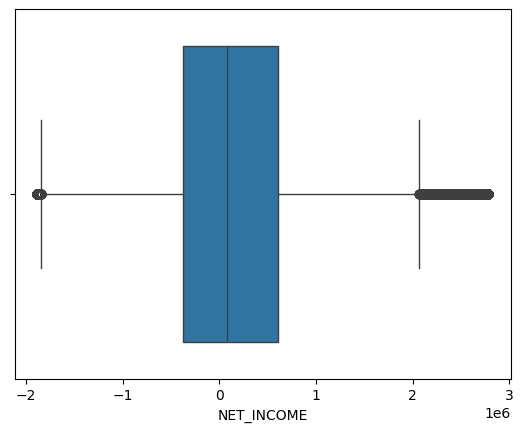

In [19]:
# Check the distribution again after winsorization
sns.boxplot(x=df_COST_dropna['NET_INCOME'])

**🔹Check for null values in NET_INCOME again**

In [20]:
nullNetIncome = (df_COST_dropna['NET_INCOME'].isnull().sum()/len(df_COST))*100
print(nullNetIncome)

0.0


In [21]:
# Rename dataset with a cleaner reference name
df_COSTclean = df_COST_dropna

In [22]:
#Check amount of rows and columns again after cleaning
amt_rows = df_COSTclean.shape[0]
amt_columns = df_COSTclean.shape[1]
print("df_COST amount of rows:", amt_rows)
print("df_COST amount of columns:", amt_columns)

df_COST amount of rows: 106269
df_COST amount of columns: 70


### **◼ Additional Cleaning of df_PROVIDER**

**🔹 Check the amount of rows and columns before cleaning**

In [23]:
amt_rows = df_PROVIDER.shape[0]
amt_columns = df_PROVIDER.shape[1]
print("df_PROVIDER amount of rows:", amt_rows)
print("df_PROVIDER amount of columns:", amt_columns)

df_PROVIDER amount of rows: 108637
df_PROVIDER amount of columns: 100


In [24]:
#CHECK FOR NA IN EACH DATASET - df_PROVIDER
df_PROVIDER.isna().sum()

PROVNUM                                                        0
PROVNAME                                                       0
ADDRESS                                                        0
CITY                                                           0
STATE                                                          0
                                                           ...  
CM_RN                                                      64244
CM_TOTAL                                                   64244
AVERAGE NUMBER OF RESIDENTS PER DAY FOOTNOTE              108502
LOCATION                                                   78025
NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS     93424
Length: 100, dtype: int64

In [25]:
# Check to see which variables in df_PROVIDER have more than 50% null values
nullPercent = (df_PROVIDER.isnull().sum() / len(df_PROVIDER)) * 100
highNullPercent = nullPercent[nullPercent >50]
sort_highNullPercent = highNullPercent.sort_values(ascending=False)
print(sort_highNullPercent)

AVERAGE NUMBER OF RESIDENTS PER DAY FOOTNOTE              99.875733
SURVEY_RATING_FN                                          98.851220
QUALITY_RATING_FN                                         98.666200
SFFSTATUS                                                 98.538251
OVERALL_RATING_FN                                         98.442520
LS_QUALITY_RATING_FN                                      98.244613
STAFFING_FLAG                                             96.424791
PT_STAFFING_FLAG                                          96.417427
SS_QUALITY_RATING_FN                                      94.149323
RN_STAFFING_RATING_FN                                     92.756611
STAFFING_RATING_FN                                        92.756611
R_HTH_SVRTY                                               86.712630
R_HTH_SCOPE                                               86.712630
NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS    85.996484
PREV_TOT_HTH_DFCNCY                             

In [26]:
#Get the names of the columns that are needed to drop
print(highNullPercent.index)

Index(['OVERALL_RATING_FN', 'SURVEY_RATING_FN', 'QUALITY_RATING_FN',
       'STAFFING_RATING_FN', 'RN_STAFFING_RATING_FN', 'STAFFING_FLAG',
       'PT_STAFFING_FLAG', 'R_SRVY_DT_F', 'R_TOT_HTH_DFCNCY', 'R_HTH_SVRTY',
       'R_HTH_SCOPE', 'PREV_SRVY_DT_F', 'PREV_TOT_HTH_DFCNCY', 'SFFSTATUS',
       'ABUSE_ICON', 'LS_QUALITY_RATING', 'LS_QUALITY_RATING_FN',
       'SS_QUALITY_RATING', 'SS_QUALITY_RATING_FN', 'CM_AIDE', 'CM_LPN',
       'CM_RN', 'CM_TOTAL', 'AVERAGE NUMBER OF RESIDENTS PER DAY FOOTNOTE',
       'LOCATION', 'NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS'],
      dtype='object')


In [27]:
# Drop the columns that have more than 50% null values
df_PROVIDER_dropna = df_PROVIDER.drop(labels = ['OVERALL_RATING_FN', 'SURVEY_RATING_FN', 'QUALITY_RATING_FN',
                                            'STAFFING_RATING_FN', 'RN_STAFFING_RATING_FN', 'STAFFING_FLAG',
                                            'PT_STAFFING_FLAG', 'R_SRVY_DT_F', 'R_TOT_HTH_DFCNCY', 'R_HTH_SVRTY',
                                            'R_HTH_SCOPE', 'PREV_SRVY_DT_F', 'PREV_TOT_HTH_DFCNCY', 'SFFSTATUS',
                                            'ABUSE_ICON', 'LS_QUALITY_RATING', 'LS_QUALITY_RATING_FN',
                                            'SS_QUALITY_RATING', 'SS_QUALITY_RATING_FN', 'CM_AIDE', 'CM_LPN',
                                            'CM_RN', 'CM_TOTAL', 'AVERAGE NUMBER OF RESIDENTS PER DAY FOOTNOTE',
                                            'LOCATION', 'NUMBER OF CITATIONS FROM INFECTION CONTROL INSPECTIONS'], axis=1)

**🔹 df_PROVIDER has provider descriptors for each year. For numerical data we are taking the average values and for categorical data we are taking the last indicated attribute within each categorical variable**

In [28]:
#Distinguish between numerical and categorical columns within the provider dataset
providerNumericCol = df_PROVIDER_dropna.select_dtypes(include='number').columns
providerCategoricalCol = df_PROVIDER_dropna.select_dtypes(exclude='number').columns

# Define aggregation functions
agg_functions = {}
for col in providerNumericCol:
    agg_functions[col] = 'mean'
for col in providerCategoricalCol:
    if col != 'PROVNUM':
        agg_functions[col] = 'last'

# Group by 'PROVNUM' column and aggregate using defined functions
df_PROVIDER_dedup = df_PROVIDER_dropna.groupby('PROVNUM').agg(agg_functions).reset_index()

print(df_PROVIDER_dedup)

      PROVNUM      ZIP         PHONE  COUNTY_SSA  BEDCERT      RESTOT  \
0      01A193  36108.0  3.348346e+09       500.0     58.0   50.300000   
1      01A208  36110.0  3.342613e+09       500.0     54.0   48.185714   
2      04A158  72404.0  8.709335e+09       150.0    121.0   97.200000   
3      04A293  72015.0  5.018600e+09       620.0    290.0  238.757143   
4      04A325  72205.0  5.012244e+09       590.0    143.0   75.000000   
...       ...      ...           ...         ...      ...         ...   
16329   95034  20017.0  2.022697e+09         0.0    252.0  218.257143   
16330   95036  20001.0  2.025352e+09         0.0    230.0  213.857143   
16331   95038  20008.0  2.029668e+09         0.0     50.0   44.142857   
16332   95039  20032.0  2.025747e+09         0.0    120.0   92.020000   
16333   95040  20017.0  2.028324e+09         0.0     16.0    4.200000   

       OVERALL_RATING  SURVEY_RATING  QUALITY_RATING  STAFFING_RATING  ...  \
0            3.142857       2.714286        4

**🔹 Compare the amount of rows and columns of cleaned dataset to old.**

This results in less rows due to the deduplication of the dataset.

In [29]:
df_PROVIDERclean = df_PROVIDER_dedup
amt_rows = df_PROVIDERclean.shape[0]
amt_columns = df_PROVIDERclean.shape[1]
print("df_PROVIDER amount of rows:", amt_rows)
print("df_PROVIDER amount of columns:", amt_columns)

df_PROVIDER amount of rows: 16334
df_PROVIDER amount of columns: 74


### **◼ Additional Cleaning of df_PENALTY**

In [30]:
amt_rows = df_PENALTY.shape[0]
amt_columns = df_PENALTY.shape[1]
print("df_PENALTY amount of rows:", amt_rows)
print("df_PENALTY amount of columns:", amt_columns)

df_PENALTY amount of rows: 71488
df_PENALTY amount of columns: 14


In [31]:
#CHECK FOR NA IN EACH DATASET - df_PENALTY
df_PENALTY.isna().sum()

PROVNUM               0
PROVNAME              0
ADDRESS               0
CITY                  0
STATE                 0
ZIP                   0
PNLTY_DATE            0
PNLTY_TYPE            0
FINE_AMT          10856
PAYDEN_STRT_DT    60632
PAYDEN_DAYS       60632
FILEDATE              0
YEAR                  0
LOCATION          38702
dtype: int64

In [32]:
# Check to see which variables in df_PENALTY have more than 50% null values
nullPercent = (df_PENALTY.isnull().sum() / len(df_PENALTY)) * 100
highNullPercent = nullPercent[nullPercent >50]
sort_highNullPercent = highNullPercent.sort_values(ascending=False)
print(sort_highNullPercent)

PAYDEN_STRT_DT    84.814235
PAYDEN_DAYS       84.814235
LOCATION          54.137757
dtype: float64


In [33]:
print(highNullPercent.index)

Index(['PAYDEN_STRT_DT', 'PAYDEN_DAYS', 'LOCATION'], dtype='object')


In [34]:
df_PENALTY_dropna = df_PENALTY.drop(labels = ['PAYDEN_STRT_DT','PAYDEN_DAYS','LOCATION'], axis=1)

In [35]:
df_PENALTYclean = df_PENALTY_dropna
amt_rows = df_PENALTYclean.shape[0]
amt_columns = df_PENALTYclean.shape[1]
print("df_PENALTY amount of rows:", amt_rows)
print("df_PENALTY amount of columns:", amt_columns)

df_PENALTY amount of rows: 71488
df_PENALTY amount of columns: 11


**🔹 There weren't many details to clean in the PENALTY dataset**


## **◼ Evaluate the overall financial performance of nursing homes in the United States from 2015 - 2021**

**🔹 df_COST Overall Summary Statistics 2015 - 2021**


In [36]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
overallSummaryStats = df_COSTclean['NET_INCOME'].describe()
print(overallSummaryStats)

count     106269.00
mean      163878.99
std      1050338.59
min     -1880084.00
25%      -373518.00
50%        81514.00
75%       603637.00
max      2782130.00
Name: NET_INCOME, dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


**🔹 df_COST Summary Statistics by Year**

From the below code, we can see that 2017 and 2018 had a lower average NET_INCOME for the year.

In 2019, the average NET_INCOME began to increase again, and reached a significantly higher average in 2021 and 2021


In [37]:
yearlySummaryStats = df_COSTclean.groupby('YEAR')['NET_INCOME'].describe()

# Print the summary statistics
print(yearlySummaryStats)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

        count      mean        std         min        25%       50%       75%  \
YEAR                                                                            
2015 15402.00 178122.76  956793.61 -1880084.00 -279633.25  88883.50 524275.25   
2016 15104.00 152804.13 1030777.46 -1880084.00 -354776.75  62967.00 525488.50   
2017 15433.00  51010.79  983284.20 -1880084.00 -421016.00  11191.00 434186.00   
2018 15142.00  25449.67  960930.83 -1880084.00 -451597.75   6090.00 414534.25   
2019 15182.00 111074.55  980837.37 -1880084.00 -377792.75  53870.50 518022.00   
2020 14949.00 358325.47 1119339.56 -1880084.00 -261085.00 297486.00 949210.00   
2021 15057.00 275506.82 1251152.97 -1880084.00 -478141.00 176265.00 964887.00   

            max  
YEAR             
2015 2782130.00  
2016 2782130.00  
2017 2782130.00  
2018 2782130.00  
2019 2782130.00  
2020 2782130.00  
2021 2782130.00  


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


**🔹 Here we can see a visual representation of how NET_INCOME has fluctuated over the years.**
Overall Net Income increased from 2019-2021. This could be attributed to


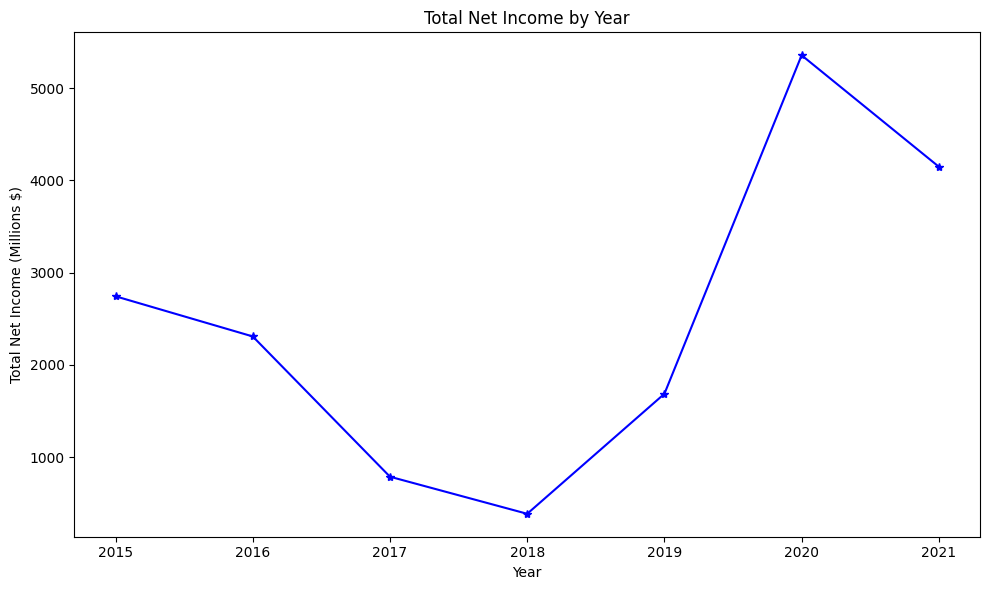

In [38]:
# Group by 'YEAR' column and calculate the sum of 'NET_INCOME' for each year
groupby_year = df_COSTclean.groupby('YEAR')['NET_INCOME'].sum()

# Plotting the total net income over the years
plt.figure(figsize=(10, 6))
plt.plot(groupby_year.index, groupby_year.values/1000000, marker='*', linestyle='-', color='blue')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Total Net Income by Year')

# Display the plot
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

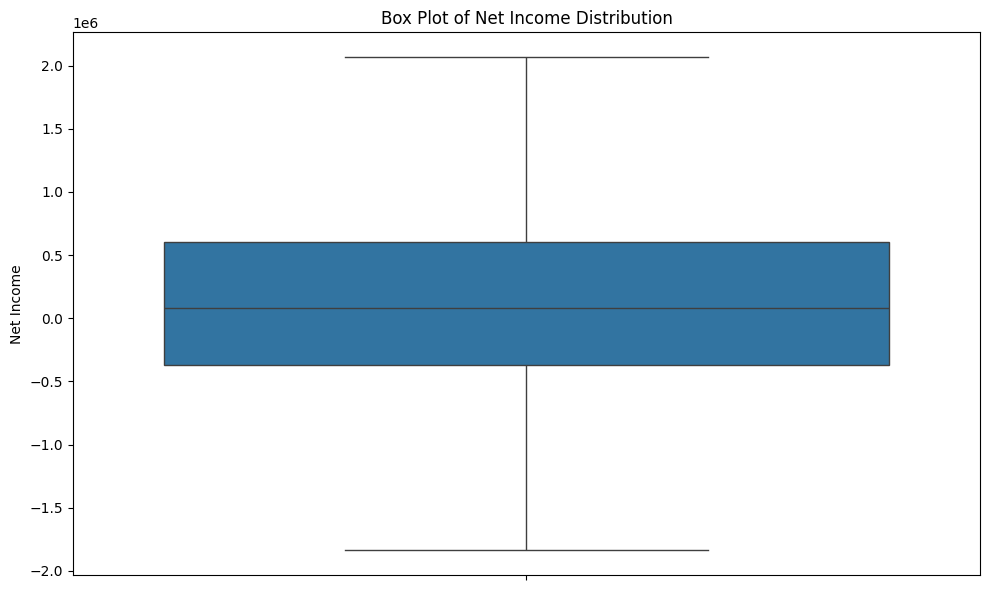

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='NET_INCOME', data=df_COSTclean, showfliers=False)
plt.title('Box Plot of Net Income Distribution')
plt.ylabel('Net Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

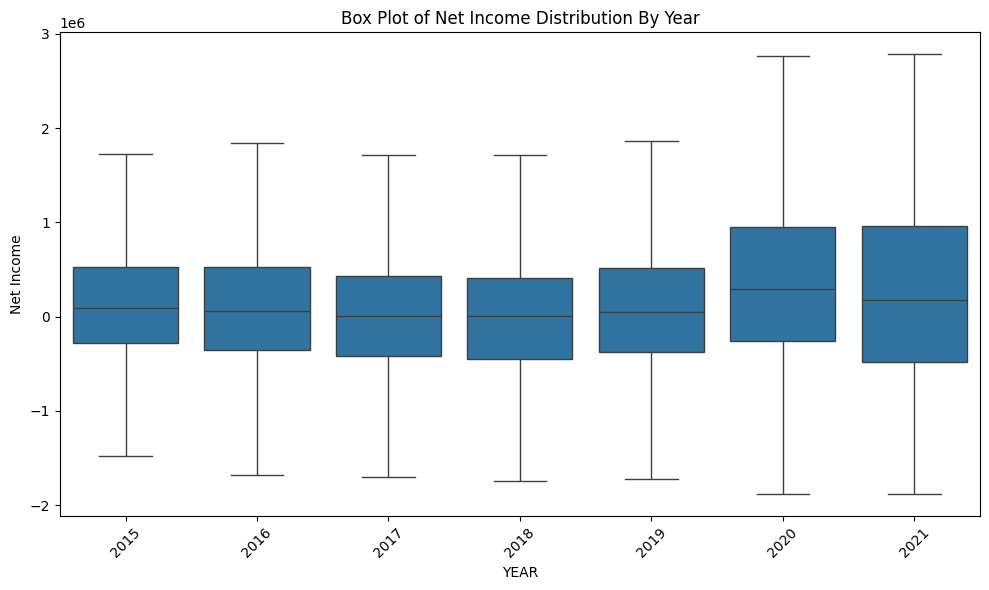

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='NET_INCOME', x='YEAR',data=df_COSTclean, showfliers = False)
plt.title('Box Plot of Net Income Distribution By Year')
plt.ylabel('Net Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **◼ Analytical Questions**

## **◼ AQ1: Are there specific types of Nursing Home Facilities that are more profitable?**

### **🔹 Rural vs. Urban**

In [41]:
RVUSummaryStats = df_COSTclean.groupby('RURAL_VERSUS_URBAN')['NET_INCOME'].describe()

# Print the summary statistics
print(RVUSummaryStats)

                      count      mean        std         min        25%  \
RURAL_VERSUS_URBAN                                                        
R                  28306.00 115350.35  728007.09 -1880084.00 -222549.50   
U                  75776.00 110527.56 1075291.56 -1880084.00 -480231.50   

                        50%       75%        max  
RURAL_VERSUS_URBAN                                
R                  70630.50 412327.50 2782130.00  
U                  63345.50 632333.00 2782130.00  


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [42]:
RVUCounts = df_COSTclean['RURAL_VERSUS_URBAN'].value_counts()
RVUPercent = (df_COSTclean['RURAL_VERSUS_URBAN'].value_counts() / df_COSTclean['RURAL_VERSUS_URBAN'].count()) * 100
print(RVUCounts)
print(RVUPercent)

RURAL_VERSUS_URBAN
U    75776
R    28306
Name: count, dtype: int64
RURAL_VERSUS_URBAN
U   72.80
R   27.20
Name: count, dtype: float64


**🔹 Visualize the NET_INCOME trends between urban and rural facilities from 2015-2021**

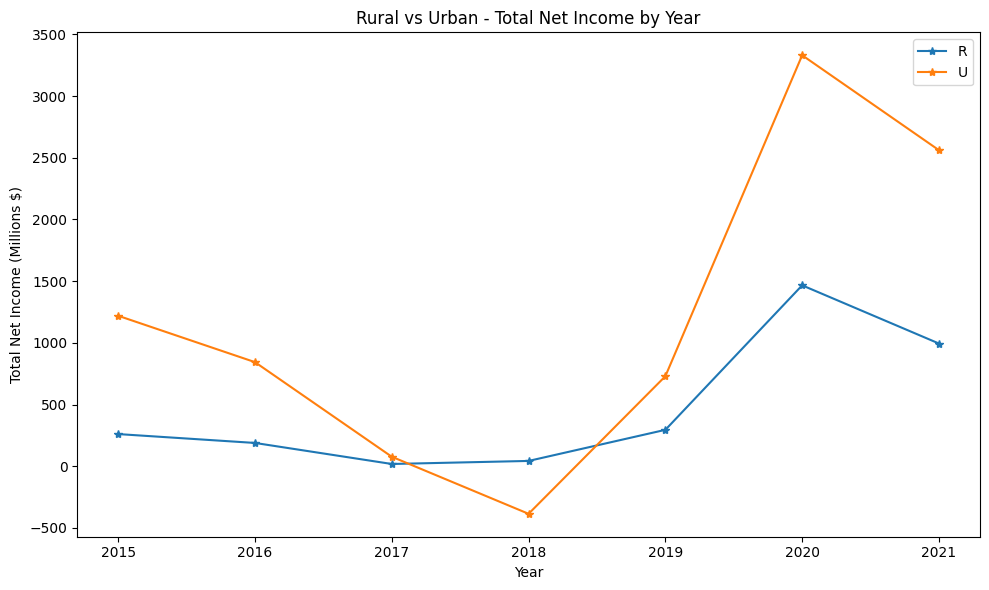

In [43]:
# Group by 'RURAL_VERSUS_URBAN' column
groupbyRuralUrban = df_COSTclean.groupby(['YEAR', 'RURAL_VERSUS_URBAN'])['NET_INCOME'].sum()
summary_statistics = groupbyRuralUrban.reset_index()

plt.figure(figsize=(10, 6))

# Iterate over unique values in 'RURAL_VERSUS_URBAN' column
for category in summary_statistics['RURAL_VERSUS_URBAN'].unique():
    # Filter data for the current category
    category_data = summary_statistics[summary_statistics['RURAL_VERSUS_URBAN'] == category]
    # Plot the data
    plt.plot(category_data['YEAR'], category_data['NET_INCOME']/1000000, marker='*', label=category)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Rural vs Urban - Total Net Income by Year')
plt.legend()
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

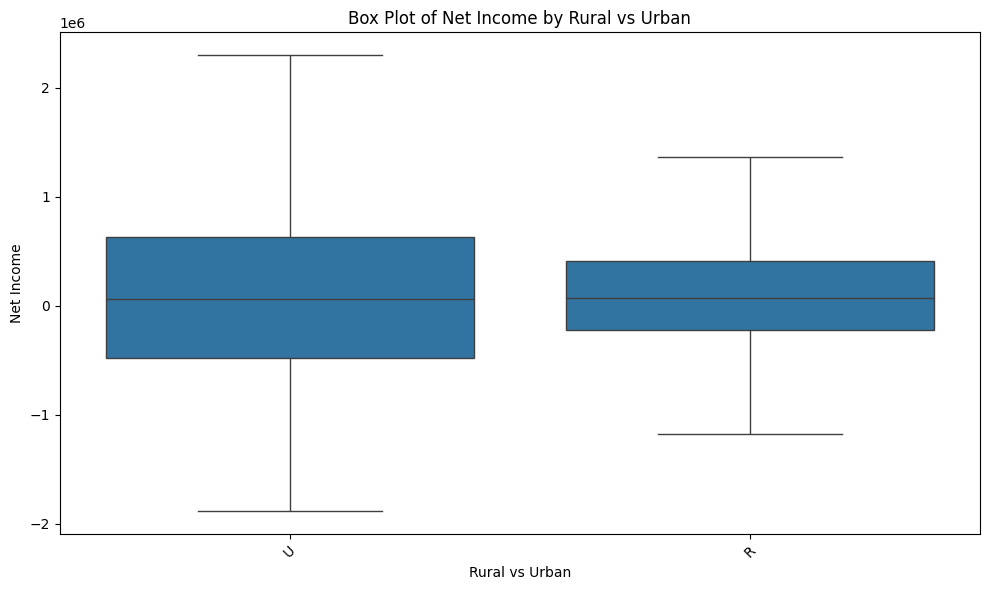

In [180]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='NET_INCOME', x='RURAL_VERSUS_URBAN', data=df_COSTclean, showfliers=False)
plt.title('Box Plot of Net Income by Rural vs Urban')
plt.xlabel('Rural vs Urban')
plt.ylabel('Net Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**🔹 Is the difference in NET_INCOME between Rural vs. Urban facilities significant?**

In [44]:
# Drop rows with missing values in the 'Rural_versus_Urban' column and keep only 'U' and 'R'
df_filtered = df_COST[df_COST['RURAL_VERSUS_URBAN'].isin(['U', 'R'])].dropna(subset=['RURAL_VERSUS_URBAN'])

# Select only numerical columns
numerical_columns = df_filtered.select_dtypes(include='number')

# Handle missing values with the mean of each numerical column
df_imputed = numerical_columns.fillna(numerical_columns.mean())

# Select only categorical columns
categorical_columns = df_filtered.select_dtypes(exclude='number')

# Handle missing values with the most frequent value (mode) of each categorical column
df_imputed_categorical = categorical_columns.fillna(categorical_columns.mode().iloc[0])

In [45]:
from scipy.stats import ttest_ind

# Separate the data into two groups based on the facility type
urban_profits = df_filtered[df_filtered['RURAL_VERSUS_URBAN'] == 'U']['NET_INCOME']
rural_profits = df_filtered[df_filtered['RURAL_VERSUS_URBAN'] == 'R']['NET_INCOME']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits, rural_profits, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.8672439497172566
P-value: 0.00011013937849576363


**🔹 The low p-value indicates that there is a significant difference in NET_INCOME between Rural and Urban facilities**

### **🔹 Ownership Type**

In [46]:
# Perform VLOOKUP-like operation by merging the DataFrames
# Add in "OWNERSHIP" attribute from df_PROVIDER to df_COST
ownershipMerge = pd.merge(df_COSTclean, df_PROVIDERclean[['PROVNUM', 'OWNERSHIP']], on='PROVNUM', how='left')

# Check for null variables in the added "OWNERSHIP" column
nan_count = ownershipMerge['OWNERSHIP'].isna().sum()
print(nan_count)

68


In [47]:
ownershipMerge.head(10)

,RPT_REC_NUM,PROVNUM,FACILITY_NAME,STREET_ADDRESS,CITY,STATE_CODE,ZIP_CODE,COUNTY,MEDICARE_CBSA_NUMBER,RURAL_VERSUS_URBAN,...,TOTAL_SALARIES_FROM_WORKSHEET_A,TOTAL_SALARIES_ADJUSTED,TOTAL_CURRENT_LIABILITIES,TOTAL_FIXED_ASSETS,TOTAL_FUND_BALANCES,TOTAL_LIABILITIES,TOTAL_OTHER_ASSETS,WAGE_RELATED_COSTS_CORE,YEAR,OWNERSHIP
0,1089712,495134,RIDGECREST MANOR NURSING & REHAB CTR,157 ROSS-CARTER BLVD,DUFFIELD,VA,24244,SCOTT,28700.00,U,...,660232.00,660232.00,453591.00,55061.00,311430.00,453590.00,-729268.00,80664.00,2015,For profit - Individual
1,1091410,75417,REGENCY HEIGHTS OF NORWICH LLC,60 CROUCH AVENUE,NORWICH,CT,6360,NEW LONDON,35980.00,U,...,1118860.00,1118860.00,2765768.00,671306.00,-4896947.00,6584403.00,36000.00,559430.00,2015,For profit - Partnership
2,1093283,165252,WESTVIEW ACRES CARE CENTER,203 SW LORRAINE,LEON,IA,50144,DECATUR,99916.00,R,...,348614.00,348614.00,192098.00,NaN,52141.00,192098.00,NaN,42209.00,2015,For profit - Corporation
3,1095547,225497,VERO HEALTH & REHAB PARKWAY,1190 VFW PARKWAY,WEST ROXBURY,MA,2132,SUFFOLK,14454.00,U,...,601118.00,601118.00,1824376.00,26949.00,6382.00,1824376.00,74985.00,113676.00,2015,For profit - Partnership
4,1095966,265161,WILSONS CREEK NURSING & REHAB,3403 WEST MT VERNON,SPRINGFIELD,MO,65802,GREENE,44180.00,U,...,363088.00,363088.00,808822.00,NaN,-1613.00,808822.00,NaN,99778.00,2015,For profit - Corporation
5,1095967,265239,HERMITAGE NURSING & REHAB,1ST STREET & US HWY 54,HERMITAGE,MO,65669,HICKORY,99926.00,R,...,207590.00,207590.00,489774.00,NaN,-26574.00,489774.00,NaN,76857.00,2015,For profit - Limited Liability company
6,1098814,265322,NIXA NURSING & REHAB,1104 N MAIN,NIXA,MO,65714,CHRISTIAN,44180.00,U,...,209681.00,209681.00,458675.00,1885.00,-28401.00,453693.00,NaN,51777.00,2015,For profit - Corporation
7,1099059,455936,SAGE HEALTHCARE CENTER,1201 NORTH 15TH ST.,LAMESA,TX,79331-3025,DAWSON,99945.00,R,...,54619.00,54619.00,30995.00,675299.00,827484.00,30995.00,NaN,7333.00,2015,For profit - Corporation
8,1100296,265428,LEBANON SOUTH NURSING & REHAB,514 WEST FREMONT RD,LEBANON,MO,65536,LACLEDE,99926.00,R,...,221608.00,221608.00,594901.00,1838.00,-73974.00,596663.00,NaN,57237.00,2015,For profit - Corporation
9,1100668,265538,ROARING RIVER HEALTH AND REHABILITAT,812 OLD EXETER ROAD,CASSVILLE,MO,65625,BARRY,99926.00,R,...,427928.00,427928.00,644746.00,NaN,-42473.00,644746.00,11734.00,56539.00,2015,For profit - Partnership


In [48]:
OWNERSHIPSummaryStats = ownershipMerge.groupby('OWNERSHIP')['NET_INCOME'].describe()

# Print the summary statistics
print(OWNERSHIPSummaryStats)

                                          count      mean        std  \
OWNERSHIP                                                              
For profit - Corporation               53861.00 169008.98  952738.89   
For profit - Individual                 5966.00 189996.11  949695.28   
For profit - Limited Liability company 13541.00 161990.71 1012156.87   
For profit - Partnership                5416.00 276688.09 1035659.67   
Government - City                        512.00  68535.81  899736.63   
Government - City/county                 414.00 146740.76 1044964.76   
Government - County                     2334.00 116848.52 1175140.05   
Government - Federal                      86.00 349183.53 1337743.16   
Government - Hospital district          1306.00 186492.61  918549.03   
Government - State                       729.00 450847.23 1680486.27   
Non profit - Church related             2577.00 114102.34 1240267.30   
Non profit - Corporation               17164.00 126345.24 128805

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

In [49]:
ownerCounts = ownershipMerge['OWNERSHIP'].value_counts()
ownerPercent = (ownershipMerge['OWNERSHIP'].value_counts() / ownershipMerge['OWNERSHIP'].count()) * 100
print(ownerCounts)
print(ownerPercent)

OWNERSHIP
For profit - Corporation                  53861
Non profit - Corporation                  17164
For profit - Limited Liability company    13541
For profit - Individual                    5966
For profit - Partnership                   5416
Non profit - Church related                2577
Government - County                        2334
Non profit - Other                         2295
Government - Hospital district             1306
Government - State                          729
Government - City                           512
Government - City/county                    414
Government - Federal                         86
Name: count, dtype: int64
OWNERSHIP
For profit - Corporation                 50.72
Non profit - Corporation                 16.16
For profit - Limited Liability company   12.75
For profit - Individual                   5.62
For profit - Partnership                  5.10
Non profit - Church related               2.43
Government - County                       2.20
N

**🔹 Visualize the NET_INCOME trends between ownership types from 2015-2021**

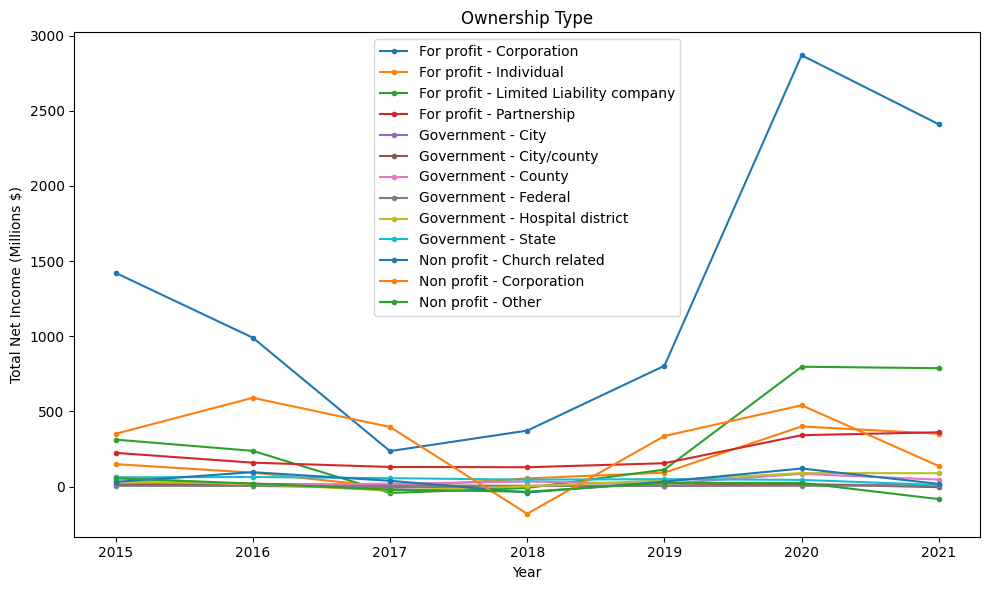

In [50]:
# Group by 'OWNERSHIP' column
groupbyOwnership = ownershipMerge.groupby(['YEAR', 'OWNERSHIP'])['NET_INCOME'].sum()
summary_statistics = groupbyOwnership.reset_index()

plt.figure(figsize=(10, 6))

# Iterate over unique values in 'OWNERSHIP' column
for category in summary_statistics['OWNERSHIP'].unique():
    # Filter data for the current category
    category_data = summary_statistics[summary_statistics['OWNERSHIP'] == category]
    # Plot the data
    plt.plot(category_data['YEAR'], category_data['NET_INCOME']/1000000, marker='.', label=category)

plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Ownership Type')
plt.legend()
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

**🔹Most Ownership types had generally steady net income from 2015 - 2021.**

'For Profit - Corporation' and 'For Profit - Individual' had the most fluctuation.

- Maybe there is something that we can investigate further - are corporation type facilities more volatile?
- Is there more risk associated with volatility? (i.e., are these types of facilities less profitable over time?)

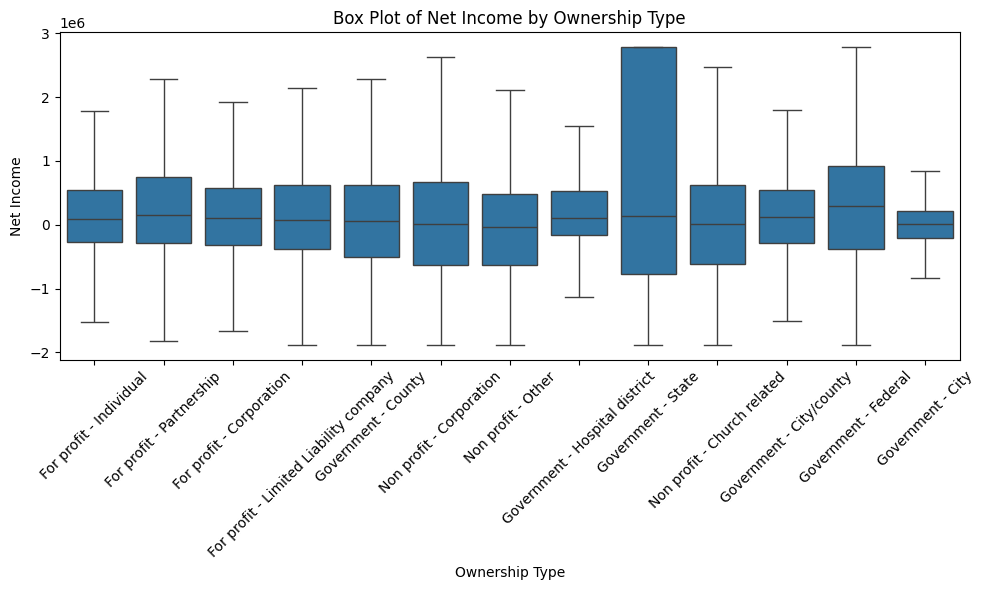

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='NET_INCOME', x='OWNERSHIP', data=ownershipMerge, showfliers=False)
plt.title('Box Plot of Net Income by Ownership Type')
plt.xlabel('Ownership Type')
plt.ylabel('Net Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**🔹Create filtered versions of the dataset to group ownership type by 'for_profit', 'non-profit', and 'govt_owned'.**


In [52]:
for_profit = ownershipMerge[(ownershipMerge['OWNERSHIP'] == 'For Profit - Corporation') |
                            (ownershipMerge['OWNERSHIP'] == 'For profit - Partnership') |
                            (ownershipMerge['OWNERSHIP'] == 'For profit - Individual') |
                            (ownershipMerge['OWNERSHIP'] == 'For profit - Limited Liability company') |
                            (ownershipMerge['OWNERSHIP'] == 'For profit - Partnership')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','YEAR','OWNERSHIP','NET_INCOME']]
non_profit = ownershipMerge[(ownershipMerge['OWNERSHIP'] == 'Non profit - Corporation') |
                            (ownershipMerge['OWNERSHIP'] == 'Non profit - Church related') |
                            (ownershipMerge['OWNERSHIP'] == 'Non profit - Other')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','YEAR','OWNERSHIP','NET_INCOME']]
govt_owned = ownershipMerge[(ownershipMerge['OWNERSHIP'] == 'Government - County') |
                            (ownershipMerge['OWNERSHIP'] == 'Government - Hospital district') |
                            (ownershipMerge['OWNERSHIP'] == 'Government - State') |
                            (ownershipMerge['OWNERSHIP'] == 'Government - City/county') |
                            (ownershipMerge['OWNERSHIP'] == 'Government - City') |
                            (ownershipMerge['OWNERSHIP'] == 'Government - Federal')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','YEAR','OWNERSHIP','NET_INCOME']]

In [53]:
# ownershipMerge df contains duplicates for net income records. Used the code below to drop duplicates on the combination of prov num, year and net income value
for_profit_deduplicated = for_profit.drop_duplicates(subset=['PROVNUM', 'YEAR', 'NET_INCOME'])
non_profit_deduplicated = non_profit.drop_duplicates(subset=['PROVNUM', 'YEAR', 'NET_INCOME'])
govt_owned_deduplicated = govt_owned.drop_duplicates(subset=['PROVNUM', 'YEAR', 'NET_INCOME'])


In [54]:
nullPercent_profit = (for_profit_deduplicated.isnull().sum() / len(for_profit_deduplicated)) * 100
nullPercent_nprof = (non_profit_deduplicated.isnull().sum() / len(non_profit_deduplicated)) * 100
nullPercent_govt = (govt_owned_deduplicated.isnull().sum() / len(govt_owned_deduplicated)) * 100

print("%Null values for_profit:", nullPercent_profit)
print("%Null values non_profit:", nullPercent_nprof)
print("%Null values govt_owned:", nullPercent_govt)


%Null values for_profit: PROVNUM      0.00
YEAR         0.00
OWNERSHIP    0.00
NET_INCOME   0.00
dtype: float64
%Null values non_profit: PROVNUM      0.00
YEAR         0.00
OWNERSHIP    0.00
NET_INCOME   0.00
dtype: float64
%Null values govt_owned: PROVNUM      0.00
YEAR         0.00
OWNERSHIP    0.00
NET_INCOME   0.00
dtype: float64


In [55]:
# Rename variables
for_profit_clean = for_profit_deduplicated
non_profit_clean = non_profit_deduplicated
govt_owned_clean = govt_owned_deduplicated

In [56]:
print(for_profit_clean.shape[0])
print(non_profit_clean.shape[0])
print(govt_owned_clean.shape[0])

24906
22016
5368


**🔹Is there any difference in the net income by the facility's ownership type?**


In [57]:
#Is there any difference in the net income by the facility's ownership type?

from scipy.stats import f_oneway

# Perform ANOVA test
f_statistic, p_value = f_oneway(for_profit_clean['NET_INCOME'],
                                non_profit_clean['NET_INCOME'],
                                govt_owned_clean['NET_INCOME'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 31.053838516080564
P-value: 3.3227123378982e-14


In [58]:
from scipy.stats import f_oneway

# Initialize dictionaries to store results
f_statistics_by_year = {}
p_values_by_year = {}

# Iterate over unique years
for year in df_COSTclean['YEAR'].unique():
    # Filter data for the current year
    for_profit_year = for_profit_clean[for_profit_clean['YEAR'] == year]['NET_INCOME']
    non_profit_year = non_profit_clean[non_profit_clean['YEAR'] == year]['NET_INCOME']
    govt_owned_year = govt_owned_clean[govt_owned_clean['YEAR'] == year]['NET_INCOME']

    # Perform ANOVA test for the current year
    f_statistic, p_value = f_oneway(for_profit_year, non_profit_year, govt_owned_year)

    # Store results in dictionaries
    f_statistics_by_year[year] = f_statistic
    p_values_by_year[year] = p_value

# Print results for each year
for year in df_COSTclean['YEAR'].unique():
    print(f"Year: {year}")
    print("ANOVA F-statistic:", f_statistics_by_year[year])
    print("P-value:", p_values_by_year[year])
    print()


Year: 2015
ANOVA F-statistic: 2.673667429481298
P-value: 0.06906473311856264

Year: 2016
ANOVA F-statistic: 5.20841534562892
P-value: 0.005490307051240804

Year: 2017
ANOVA F-statistic: 8.446456606192324
P-value: 0.00021669681885187435

Year: 2018
ANOVA F-statistic: 18.59926620860709
P-value: 8.761330399890408e-09

Year: 2019
ANOVA F-statistic: 1.340693649934247
P-value: 0.2617265061436215

Year: 2020
ANOVA F-statistic: 27.049015864771214
P-value: 1.9748456428061456e-12

Year: 2021
ANOVA F-statistic: 74.82541574501124
P-value: 6.695273216302815e-33



**🔹The above code shows us how statistical significance of ownership type fluctuated throughout the years**


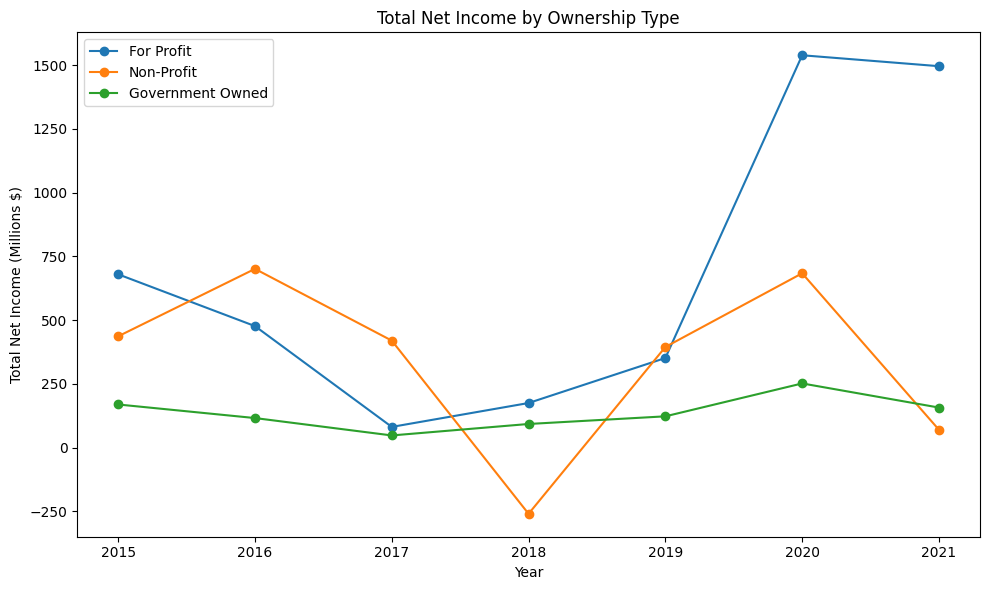

In [59]:
import matplotlib.pyplot as plt

# Function that takes the region dfs previously defined and the region name to plot net income for each year
def plot_net_income_ownership(df, region_name):
    # Group by 'YEAR' and calculate sum of 'NET_INCOME' for each year
    groupby_year = df.groupby('YEAR')['NET_INCOME'].sum()

    # Plotting the net income for each year
    plt.plot(groupby_year.index, groupby_year.values/1000000, marker='o', label=region_name)

# Plot net income for each region
plt.figure(figsize=(10, 6))

plot_net_income_ownership(for_profit_clean, 'For Profit')
plot_net_income_ownership(non_profit_clean, 'Non-Profit')
plot_net_income_ownership(govt_owned_clean, 'Government Owned')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Total Net Income by Ownership Type')
plt.legend()

# Display the plot
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

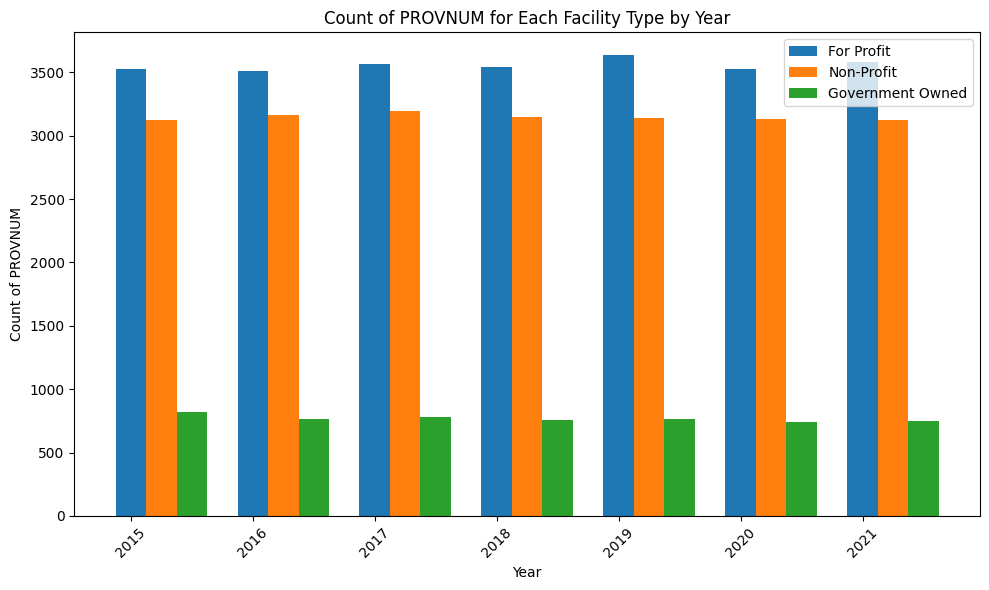

In [60]:
import matplotlib.pyplot as plt

# Function to plot count of PROVNUM for each facility type by year
def plot_facility_count_by_year(for_profit_df, non_profit_df, govt_owned_df):
    # Group by 'YEAR' and 'OWNERSHIP' and calculate the count of 'PROVNUM' for each combination
    for_profit_counts = for_profit_df.groupby('YEAR')['PROVNUM'].count()
    non_profit_counts = non_profit_df.groupby('YEAR')['PROVNUM'].count()
    govt_owned_counts = govt_owned_df.groupby('YEAR')['PROVNUM'].count()

    plt.figure(figsize=(10, 6))
    plt.bar(for_profit_counts.index, for_profit_counts.values, width=0.25, label='For Profit')
    plt.bar(non_profit_counts.index + 0.25, non_profit_counts.values, width=0.25, label='Non-Profit')
    plt.bar(govt_owned_counts.index + 0.5, govt_owned_counts.values, width=0.25, label='Government Owned')

    plt.xlabel('Year')
    plt.ylabel('Count of PROVNUM')
    plt.title('Count of PROVNUM for Each Facility Type by Year')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot count of PROVNUM for each facility type by year
plot_facility_count_by_year(for_profit_deduplicated, non_profit_deduplicated, govt_owned_deduplicated)


### **🔹 Geographic Location**

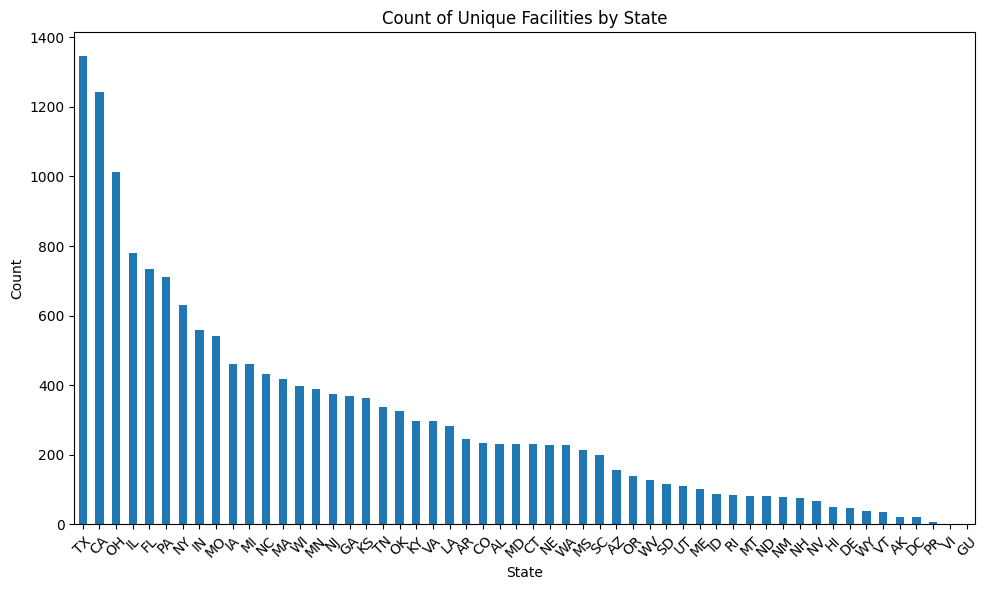

In [61]:
# Drop duplicate rows to get unique instances of PROVNUM and STATE
uniqueProviders = df_PROVIDERclean.drop_duplicates(subset=['PROVNUM', 'STATE'])

# Count the number of unique facilities by state
uniqueFacilitiesState = uniqueProviders['STATE'].value_counts()

plt.figure(figsize=(10, 6))
uniqueFacilitiesState.plot(kind='bar')
plt.title('Count of Unique Facilities by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**🔹We can see that the states with the most facilities also include Texas, California, Ohio, Illinois, Florida.**



In [62]:
westStates = df_COSTclean[(df_COSTclean['STATE_CODE'] == 'CA') |(df_COSTclean['STATE_CODE'] == 'OR') |(df_COSTclean['STATE_CODE'] == 'WA') |(df_COSTclean['STATE_CODE'] == 'NV') |
                                  (df_COSTclean['STATE_CODE'] == 'ID') |(df_COSTclean['STATE_CODE'] == 'MT') |(df_COSTclean['STATE_CODE'] == 'AK') |(df_COSTclean['STATE_CODE'] == 'HI') |
                                  (df_COSTclean['STATE_CODE'] == 'WY') |(df_COSTclean['STATE_CODE'] == 'UT') |
                                  (df_COSTclean['STATE_CODE'] == 'CO') & (df_COSTclean['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','YEAR']]

southwestStates = df_COSTclean[(df_COSTclean['STATE_CODE'] == 'AZ') |(df_COSTclean['STATE_CODE'] == 'NM') |(df_COSTclean['STATE_CODE'] == 'OK') |(df_COSTclean['STATE_CODE'] == 'TX')
 & (df_COSTclean['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','YEAR']]

midwestStates = df_COSTclean[(df_COSTclean['STATE_CODE'] == 'ND') |(df_COSTclean['STATE_CODE'] == 'SD') |
                                  (df_COSTclean['STATE_CODE'] == 'NE') |(df_COSTclean['STATE_CODE'] == 'KS') |
                                  (df_COSTclean['STATE_CODE'] == 'MN') |(df_COSTclean['STATE_CODE'] == 'IA') |
                                  (df_COSTclean['STATE_CODE'] == 'MO') |(df_COSTclean['STATE_CODE'] == 'WI') |
                                  (df_COSTclean['STATE_CODE'] == 'IL') |(df_COSTclean['STATE_CODE'] == 'IN') |
                                  (df_COSTclean['STATE_CODE'] == 'MI') |(df_COSTclean['STATE_CODE'] == 'OH')
                                  & (df_COSTclean['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','YEAR']]

northeastStates = df_COSTclean[(df_COSTclean['STATE_CODE'] == 'PA') |(df_COSTclean['STATE_CODE'] == 'NY') |(df_COSTclean['STATE_CODE'] == 'VT') |(df_COSTclean['STATE_CODE'] == 'ME') |
                                  (df_COSTclean['STATE_CODE'] == 'NH') |(df_COSTclean['STATE_CODE'] == 'MA') |
                                  (df_COSTclean['STATE_CODE'] == 'CT') |(df_COSTclean['STATE_CODE'] == 'RI') |
                                  (df_COSTclean['STATE_CODE'] == 'NJ') |(df_COSTclean['STATE_CODE'] == 'DE') |(df_COSTclean['STATE_CODE'] == 'MD')
                                  & (df_COSTclean['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','YEAR']]

southeastStates = df_COSTclean[(df_COSTclean['STATE_CODE'] == 'AR') |(df_COSTclean['STATE_CODE'] == 'LA') |(df_COSTclean['STATE_CODE'] == 'MS') |(df_COSTclean['STATE_CODE'] == 'TN') |
                                  (df_COSTclean['STATE_CODE'] == 'KY') |(df_COSTclean['STATE_CODE'] == 'AL') |
                                  (df_COSTclean['STATE_CODE'] == 'WV') |(df_COSTclean['STATE_CODE'] == 'VA') |(df_COSTclean['STATE_CODE'] == 'FL')|
                                  (df_COSTclean['STATE_CODE'] == 'NC') |(df_COSTclean['STATE_CODE'] == 'SC') |(df_COSTclean['STATE_CODE'] == 'GA')
                                  & (df_COSTclean['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','YEAR']]

In [63]:
from scipy.stats import f_oneway

# Perform ANOVA test
f_statistic, p_value = f_oneway(westStates['NET_INCOME'], midwestStates['NET_INCOME'], southwestStates['NET_INCOME'], northeastStates['NET_INCOME'], southeastStates['NET_INCOME'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 187.06565588987712
P-value: 4.550117155865948e-160


In [64]:
from scipy.stats import f_oneway

f_statistics_by_year = {}
p_values_by_year = {}

for year in df_COSTclean['YEAR'].unique():
    # Filter data for the current year
    westStates_year = westStates[westStates['YEAR'] == year]['NET_INCOME']
    midwestStates_year = westStates[westStates['YEAR'] == year]['NET_INCOME']
    southwestStates_year = southwestStates[southwestStates['YEAR'] == year]['NET_INCOME']
    northeastStates_year = northeastStates[northeastStates['YEAR'] == year]['NET_INCOME']
    southeastStates_year = southeastStates[southeastStates['YEAR'] == year]['NET_INCOME']

    # Perform ANOVA test for the current year
    f_statistic, p_value = f_oneway(westStates_year, southwestStates_year, northeastStates_year, southeastStates_year)

    # Store results in dictionaries
    f_statistics_by_year[year] = f_statistic
    p_values_by_year[year] = p_value

for year in df_COSTclean['YEAR'].unique():
    print(f"Year: {year}")
    print("ANOVA F-statistic:", f_statistics_by_year[year])
    print("P-value:", p_values_by_year[year])
    print()

Year: 2015
ANOVA F-statistic: 51.46211730855359
P-value: 5.245271458628321e-33

Year: 2016
ANOVA F-statistic: 56.46446726490949
P-value: 3.441656237574101e-36

Year: 2017
ANOVA F-statistic: 29.55194849287473
P-value: 5.117939355723298e-19

Year: 2018
ANOVA F-statistic: 20.591386019972166
P-value: 2.689220994238337e-13

Year: 2019
ANOVA F-statistic: 11.127676676603546
P-value: 2.743529334572336e-07

Year: 2020
ANOVA F-statistic: 39.956160555453074
P-value: 1.168091827313182e-25

Year: 2021
ANOVA F-statistic: 2.067733186228947
P-value: 0.10220286711027184



**🔹 The ANOVA test above indicates that there is a significant difference between state regions**

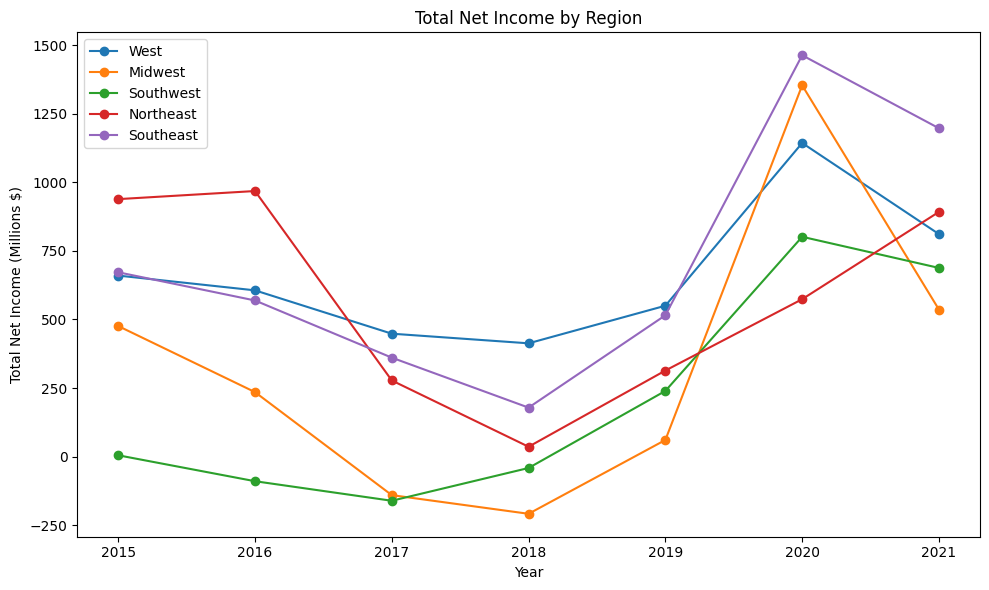

In [65]:
import matplotlib.pyplot as plt

# Function that takes the region dfs previously defined and the region name to plot net income for each year
def plot_net_income_by_region(df, region_name):
    # Group by 'YEAR' and calculate sum of 'NET_INCOME' for each year
    groupby_year = df.groupby('YEAR')['NET_INCOME'].sum()

    # Plotting the net income for each year
    plt.plot(groupby_year.index, groupby_year.values/1000000, marker='o', label=region_name)

# Plot net income for each region
plt.figure(figsize=(10, 6))

plot_net_income_by_region(westStates, 'West')
plot_net_income_by_region(midwestStates, 'Midwest')
plot_net_income_by_region(southwestStates, 'Southwest')
plot_net_income_by_region(northeastStates, 'Northeast')
plot_net_income_by_region(southeastStates, 'Southeast')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Total Net Income by Region')
plt.legend()

# Display the plot
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()


In [66]:
# Mapping dictionary for state codes to regions
region_mapping = {
    'CA': 'West',
    'OR': 'West',
    'WA': 'West',
    'NV': 'West',
    'ID': 'West',
    'MT': 'West',
    'WY': 'West',
    'UT': 'West',
    'CO': 'West',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'MN': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',
    'MI': 'Midwest',
    'AZ': 'Southwest',
    'NM': 'Southwest',
    'OK': 'Southwest',
    'TX': 'Southwest',
    'PA': 'Northeast',
    'NY': 'Northeast',
    'VT': 'Northeast',
    'ME': 'Northeast',
    'NH': 'Northeast',
    'MA': 'Northeast',
    'CT': 'Northeast',
    'RI': 'Northeast',
    'NJ': 'Northeast',
    'DE': 'Northeast',
    'MD': 'Northeast',
    'AR': 'Southeast',
    'LA': 'Southeast',
    'MS': 'Southeast',
    'TN': 'Southeast',
    'KY': 'Southeast',
    'AL': 'Southeast',
    'WV': 'Southeast',
    'VA': 'Southeast',
    'FL': 'Southeast',
    'NC': 'Southeast',
    'SC': 'Southeast',
    'GA': 'Southeast'
}


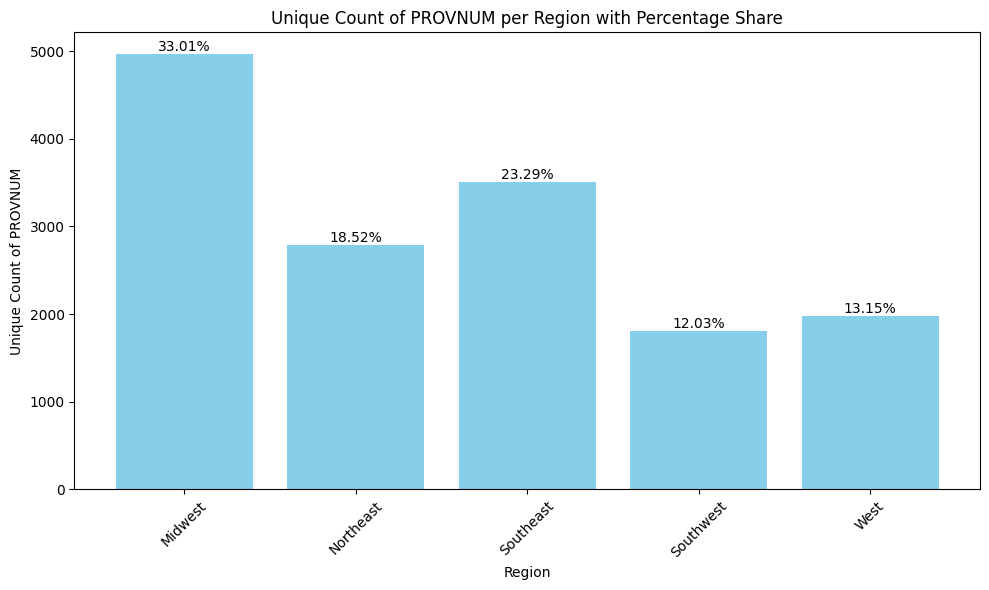

In [67]:
import matplotlib.pyplot as plt

# Concatenate all dataframes into one
df_all_states = pd.concat([westStates, midwestStates, southwestStates, northeastStates, southeastStates])

# Replace state codes with region names
df_all_states['Region'] = df_all_states['STATE_CODE'].map(region_mapping)

# Calculate the unique count of PROVNUM for each region
unique_counts = df_all_states.groupby('Region')['PROVNUM'].nunique()

# Calculate the total count of PROVNUM
total_count = unique_counts.sum()

# Calculate the percentage share of each region's PROVNUM count relative to the total count
percentage_share = (unique_counts / total_count) * 100

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(percentage_share.index, unique_counts, color='skyblue')

# Add labels with percentage share to each bar
for bar, percentage in zip(bars, percentage_share):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Region')
plt.ylabel('Unique Count of PROVNUM')
plt.title('Unique Count of PROVNUM per Region with Percentage Share')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **◼ AQ2: Is there a relationship between facility profitability and Overall Rating?**

In [68]:
RatingMerge = pd.merge(df_COSTclean, df_PROVIDERclean[['PROVNUM', 'OVERALL_RATING']], on='PROVNUM', how='left')

# Check for null variables in the added "OWNERSHIP" column
nan_count = RatingMerge['OVERALL_RATING'].isna().sum()
print(nan_count)

323


<ipython-input-70-a3fc022fc9bc>:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


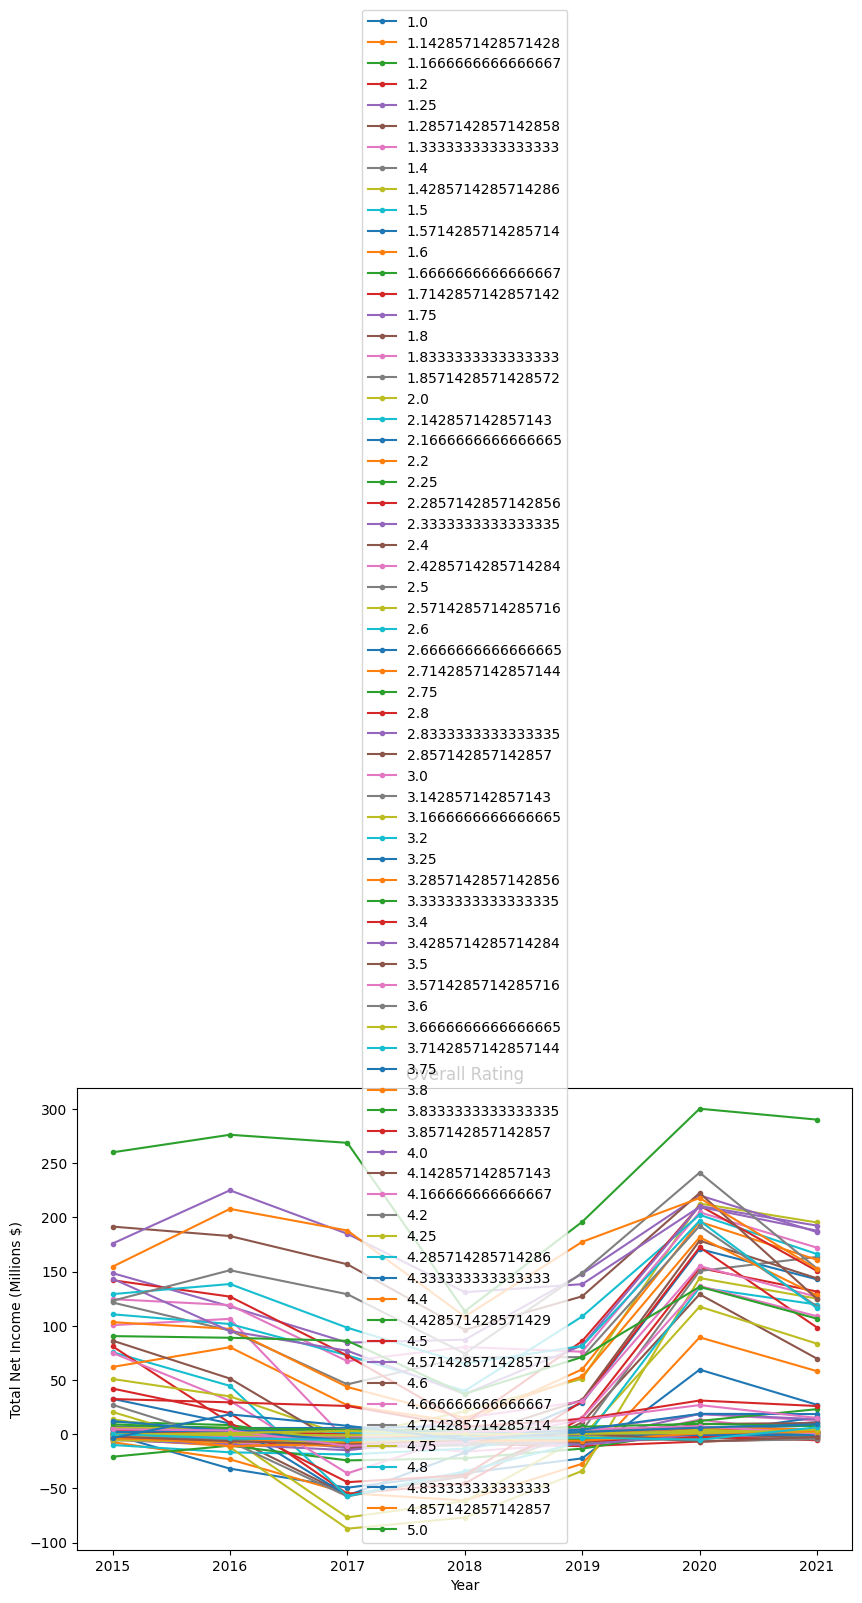

In [70]:
# Group by Rating column
groupbyRating = RatingMerge.groupby(['YEAR', 'OVERALL_RATING'])['NET_INCOME'].sum()
summary_statistics = groupbyRating.reset_index()

plt.figure(figsize=(10, 6))

# Iterate over unique values in 'OVERALL_RATING' column
for category in summary_statistics['OVERALL_RATING'].unique():
    # Filter data for the current category
    category_data = summary_statistics[summary_statistics['OVERALL_RATING'] == category]
    # Plot the data
    plt.plot(category_data['YEAR'], category_data['NET_INCOME']/1000000, marker='.', label=category)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Overall Rating')
plt.legend()
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

In [186]:
from scipy.stats import f_oneway

# Group by Rating column and round the scores
groupbyRating = RatingMerge.groupby(['YEAR', RatingMerge['OVERALL_RATING'].round()])['NET_INCOME'].sum()
summary_statistics = groupbyRating.reset_index()

# List to store net income for each category
ratings_net_income = []

# Iterate over unique values in 'OVERALL_RATING' column
for category in summary_statistics['OVERALL_RATING'].unique():
    # Filter data for the current category
    category_data = summary_statistics[summary_statistics['OVERALL_RATING'] == category]
    # Append net income values to the list
    ratings_net_income.append(category_data['NET_INCOME'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(*ratings_net_income)

# Print results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 6.0149058953999495
p-value: 0.0011190525327032807


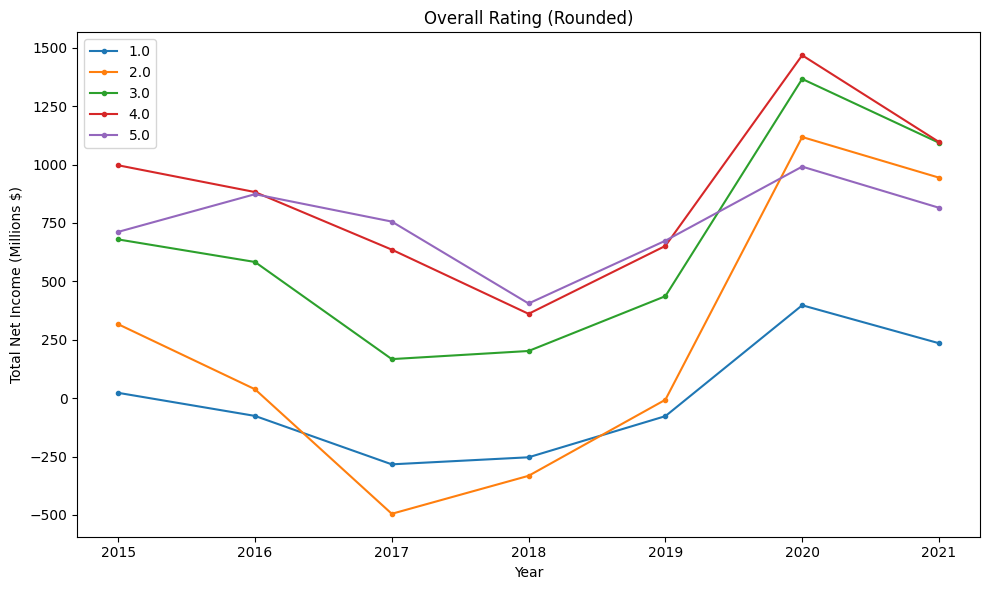

In [71]:
# Group by Rating column and round the scores
groupbyRating = RatingMerge.groupby(['YEAR', RatingMerge['OVERALL_RATING'].round()])['NET_INCOME'].sum()
summary_statistics = groupbyRating.reset_index()

plt.figure(figsize=(10, 6))

# Iterate over unique values in 'OVERALL_RATING' column
for category in summary_statistics['OVERALL_RATING'].unique():
    # Filter data for the current category
    category_data = summary_statistics[summary_statistics['OVERALL_RATING'] == category]
    # Plot the data
    plt.plot(category_data['YEAR'], category_data['NET_INCOME']/1000000, marker='.', label=category)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Net Income (Millions $)')
plt.title('Overall Rating (Rounded)')
plt.legend()
plt.xticks(range(2015, 2022))
plt.tight_layout()
plt.show()

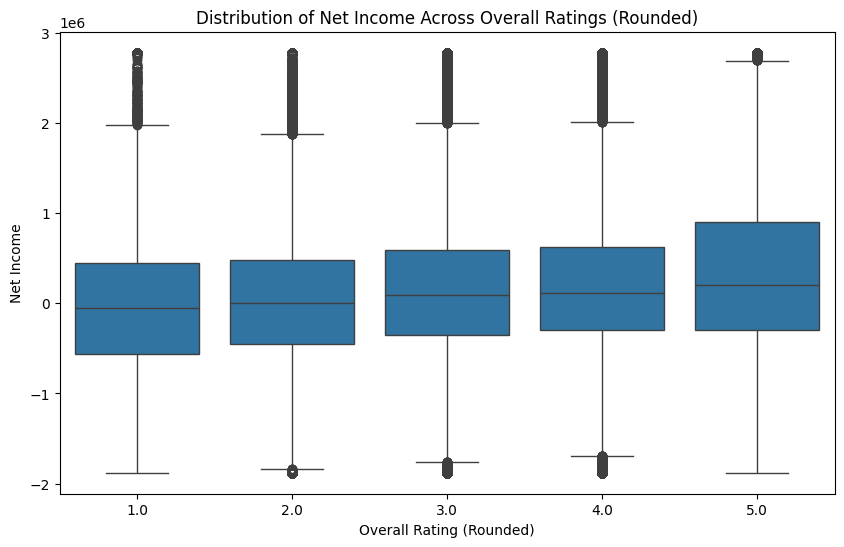

In [72]:
import seaborn as sns

# Round the overall ratings
RatingMerge['ROUNDED_OVERALL_RATING'] = RatingMerge['OVERALL_RATING'].round()

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ROUNDED_OVERALL_RATING', y='NET_INCOME', data=RatingMerge)
plt.xlabel('Overall Rating (Rounded)')
plt.ylabel('Net Income')
plt.title('Distribution of Net Income Across Overall Ratings (Rounded)')
plt.show()


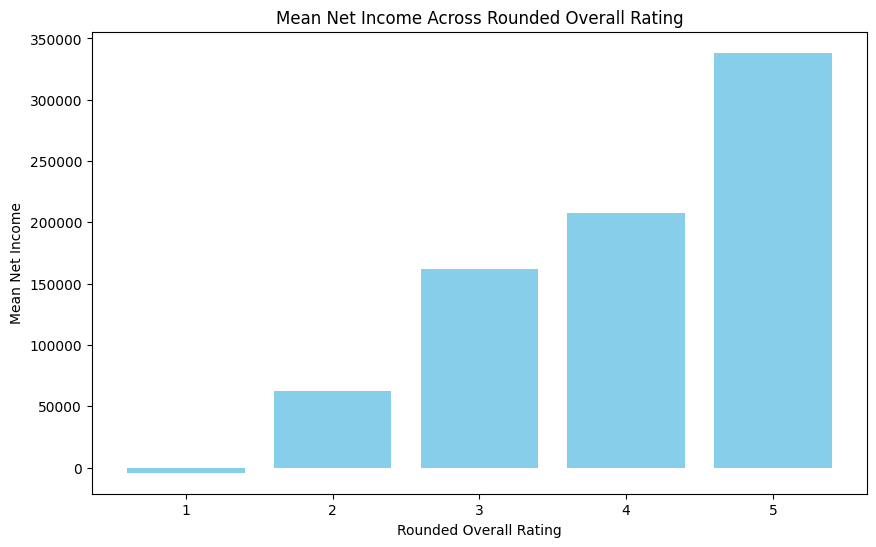

In [73]:
import matplotlib.pyplot as plt

# Round the overall rating values
RatingMerge['ROUNDED_OVERALL_RATING'] = RatingMerge['OVERALL_RATING'].round()

# Group by rounded overall rating and calculate mean net income
grouped_data = RatingMerge.groupby('ROUNDED_OVERALL_RATING')['NET_INCOME'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['ROUNDED_OVERALL_RATING'], grouped_data['NET_INCOME'], color='skyblue')
plt.xlabel('Rounded Overall Rating')
plt.ylabel('Mean Net Income')
plt.title('Mean Net Income Across Rounded Overall Rating')
plt.show()

In [74]:
import pandas as pd

# Assuming df_COST contains 'PROVNUM' and 'NET_INCOME' columns
# and df_PROVIDER contains 'PROVNUM' and 'OVERALL_RATING' columns

# Merge the dataframes on 'PROVNUM'
merged_df = pd.merge(df_COSTclean[['PROVNUM', 'NET_INCOME']], df_PROVIDERclean[['PROVNUM', 'OVERALL_RATING']], on='PROVNUM', how='inner')

# Compute the correlation coefficient
correlation = merged_df['NET_INCOME'].corr(merged_df['OVERALL_RATING'])

print("Correlation coefficient between Net Income and Overall Rating:", correlation)

Correlation coefficient between Net Income and Overall Rating: 0.09224390458226366


In [75]:
merged_df = pd.merge(df_COSTclean, df_PROVIDER, left_on='PROVNUM', right_on='PROVNUM', how='inner')
merged_df['NET_INCOME'].fillna(merged_df['NET_INCOME'].median(), inplace=True)

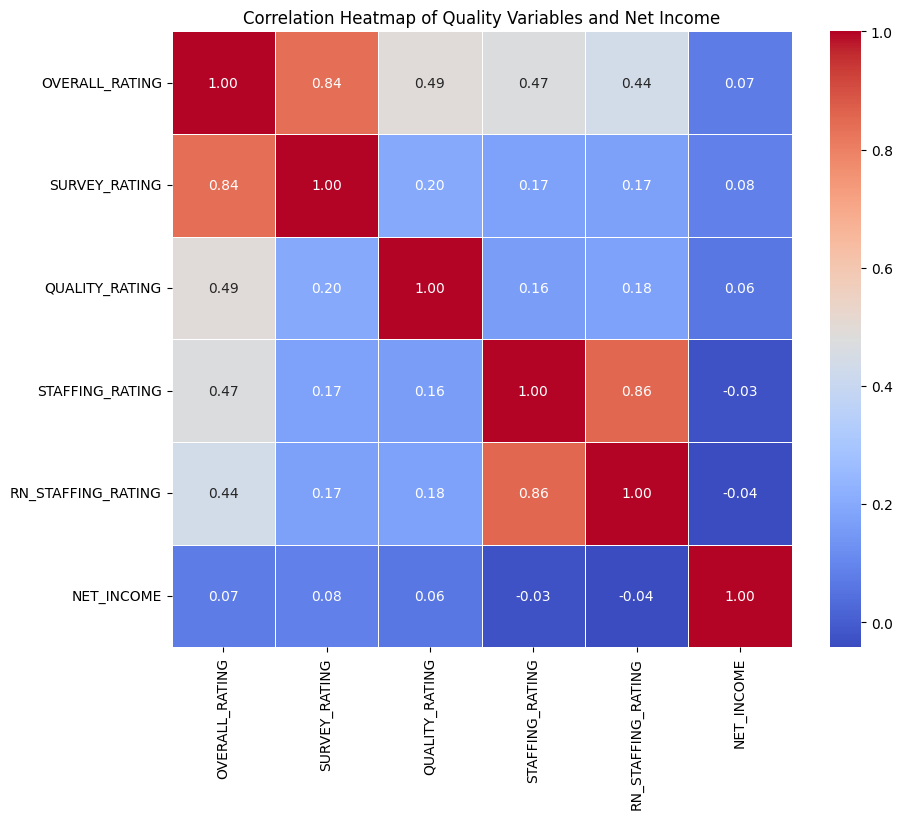

In [76]:
quality_columns = ['OVERALL_RATING', 'SURVEY_RATING', 'QUALITY_RATING', 'STAFFING_RATING', 'RN_STAFFING_RATING']
financial_columns = ['NET_INCOME']

subset_df = merged_df[quality_columns + financial_columns]

# Calculate correlation matrix
correlation_matrix = subset_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Quality Variables and Net Income')
plt.show()

## **◼ AQ3: Is there a relationship between facility profitability and penalties?**

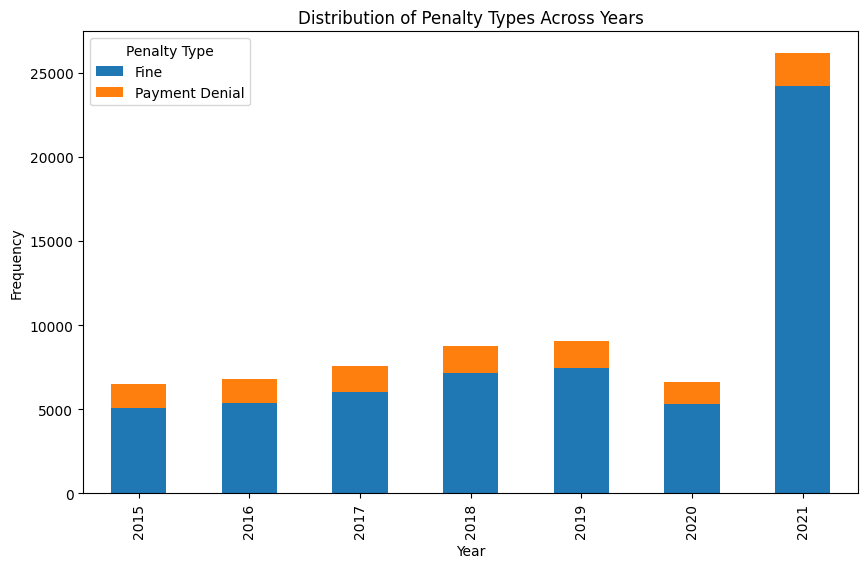

Chi-square statistic: 2041.1558405378225
P-value: 0.0


In [77]:
from scipy.stats import chi2_contingency

# Group penalty types by year
penalty_by_year = df_PENALTYclean.groupby(['YEAR', 'PNLTY_TYPE']).size().unstack(fill_value=0)

penalty_by_year.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Penalty Types Across Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Penalty Type')
plt.show()

chi2, p, dof, expected = chi2_contingency(penalty_by_year)
print(f'Chi-square statistic: {chi2}')
print(f'P-value: {p}')

In [197]:
merged_df = pd.merge(df_COST, df_PENALTY, on='PROVNUM', how='inner')

model = ols('NET_INCOME ~ C(PNLTY_TYPE)', data=merged_df).fit()

anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                              sum_sq        df     F  PR(>F)
C(PNLTY_TYPE)     249918235548675.97      1.00 59.99    0.00
Residual      2059656098664557056.00 494424.00   NaN     NaN


**🔹 There is a significant association between penalty type and year.**

The graph above also shows that the overall amount of penalties increased in 2021

**🔹 Next we looked into the relationship between penalty type and state.**


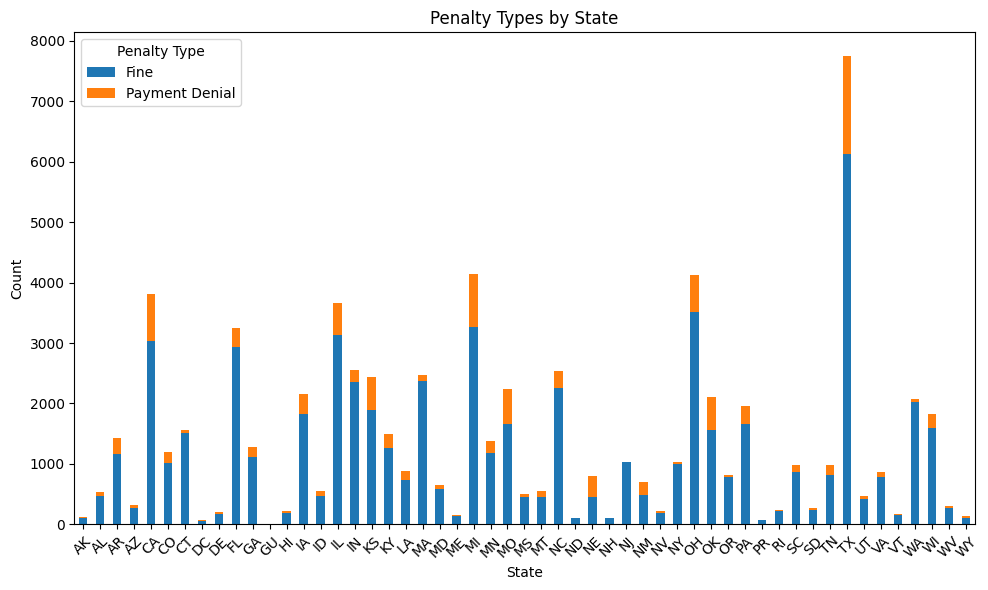

In [78]:
penalty_counts = df_PENALTYclean.groupby(['STATE', 'PNLTY_TYPE']).size().unstack(fill_value=0)

# Plot a grouped bar chart
penalty_counts.plot(kind='bar', stacked = True, figsize=(10, 6))
plt.title('Penalty Types by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Penalty Type')
plt.tight_layout()
plt.show()

**🔹 In the above bar chart, the majority of penalties are from Texas, Ohio, North Carolina, Missouri, Illinois, Florida, and California.**

These states are more likely to have more penalties because there are more facilities within the state.

In [194]:
# Summing fine amounts and averaging net income per year
fine_sum = df_PENALTYclean.groupby('YEAR')['FINE_AMT'].sum().reset_index()
net_income_avg = df_COST.groupby('YEAR')['NET_INCOME'].mean().reset_index()

# Merging data on 'YEAR'
merged_data = pd.merge(fine_sum, net_income_avg, on='YEAR', how='outer')

merged_data.sort_values('YEAR', inplace=True)


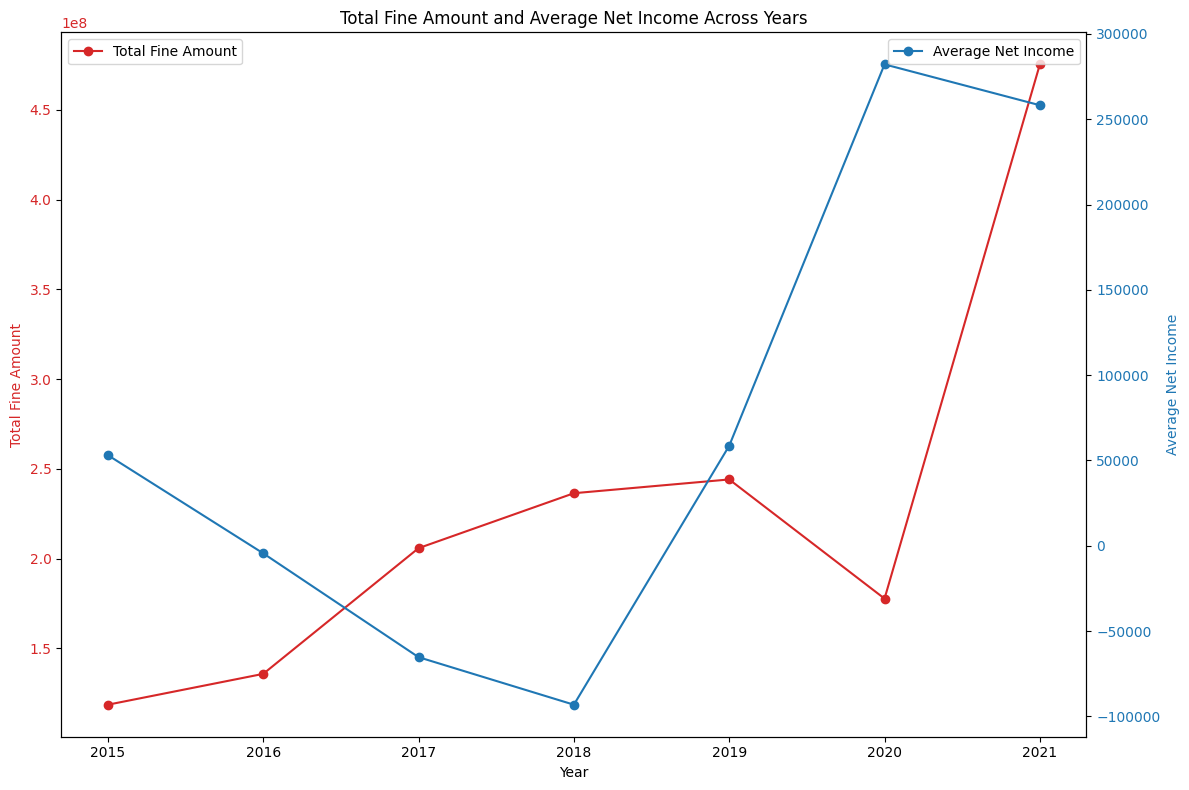

In [195]:
# Creating the figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting fine amounts on the primary Y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Fine Amount', color=color)
ax1.plot(merged_data['YEAR'], merged_data['FINE_AMT'], color=color, marker='o', label='Total Fine Amount')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary Y-axis for net income
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Net Income', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['YEAR'], merged_data['NET_INCOME'], color=color, marker='o', label='Average Net Income')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Fine Amount and Average Net Income Across Years')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# **◼COVID DATA MERGES**

## **🔹 COVID 2021 Data**

In [83]:
df_COVID = pd.read_csv('CovidVax_2021.csv')

In [84]:
print(df_COVID.columns)

Index(['Federal Provider Number', 'Provider State',
       'Percent Vaccinated Residents',
       'Percent Vaccinated Healthcare Personnel',
       'Date vaccination data last updated'],
      dtype='object')


In [85]:
column_mapping = {
    'Federal Provider Number': 'PROVNUM',
    'Percent Vaccinated Residents':'PERCENT_VAX_RES',
    'Percent Vaccinated Healthcare Personnel' : 'PERCENT_VAX_STAFF',
    'Provider State': 'STATE_CODE'}

# Rename the columns
df_COVID.rename(columns=column_mapping, inplace=True)

In [86]:
df_COVID['PROVNUM'] = df_COVID['PROVNUM'].astype(str)


In [87]:
print(df_COVID.columns)

Index(['PROVNUM', 'STATE_CODE', 'PERCENT_VAX_RES', 'PERCENT_VAX_STAFF',
       'Date vaccination data last updated'],
      dtype='object')


In [88]:
df_COVID['PROVNUM'] = df_COVID['PROVNUM'].astype(str).str.lstrip('0')


In [89]:
# Merge df_COVID with df_COSTclean to add 'RURAL_VERSUS_URBAN'
df_COVID_merged = pd.merge(df_COVID, df_COSTclean[['PROVNUM', 'RURAL_VERSUS_URBAN']], on='PROVNUM', how='left')

# Merge df_COVID_merged with df_PROVIDERclean to add 'OWNERSHIP'
df_COVID_merged = pd.merge(df_COVID_merged, df_PROVIDERclean[['PROVNUM', 'OWNERSHIP']], on='PROVNUM', how='left')

# Filter df_COSTclean to include only data for the year 2021
df_COSTclean_2021 = df_COSTclean[df_COSTclean['YEAR'] == 2021][['PROVNUM', 'NET_INCOME']]

# Merge df_COVID_merged with df_COSTclean_2021 to add 'NET_INCOME' for the year 2021
df_COVID_merged = pd.merge(df_COVID_merged, df_COSTclean_2021, on='PROVNUM', how='left')


In [90]:
df_COVID_merged.head(20)

,PROVNUM,STATE_CODE,PERCENT_VAX_RES,PERCENT_VAX_STAFF,Date vaccination data last updated,RURAL_VERSUS_URBAN,OWNERSHIP,NET_INCOME
0,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
1,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
2,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
3,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
4,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
5,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
6,15009,AL,94.0,69.8,12/12/2021,R,For profit - Corporation,814664.00
7,15010,AL,94.7,54.7,12/12/2021,U,For profit - Corporation,-26995.00
8,15010,AL,94.7,54.7,12/12/2021,U,For profit - Corporation,-26995.00
9,15010,AL,94.7,54.7,12/12/2021,R,For profit - Corporation,-26995.00


In [91]:
# Replace 'Not Available' with NaN
df_COVID_merged['PERCENT_VAX_RES'] = df_COVID_merged['PERCENT_VAX_RES'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID_merged['PERCENT_VAX_RES'] = df_COVID_merged['PERCENT_VAX_RES'].astype(float)

# Check the data types after conversion
print(df_COVID_merged.dtypes)
# Replace 'Not Available' with NaN
df_COVID_merged['PERCENT_VAX_STAFF'] = df_COVID_merged['PERCENT_VAX_STAFF'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID_merged['PERCENT_VAX_STAFF'] = df_COVID_merged['PERCENT_VAX_STAFF'].astype(float)

# Check the data types after conversion
print(df_COVID_merged.dtypes)

PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES                       float64
PERCENT_VAX_STAFF                      object
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
NET_INCOME                            float64
dtype: object
PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES                       float64
PERCENT_VAX_STAFF                     float64
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
NET_INCOME                            float64
dtype: object


In [92]:
# Group by 'PROVNUM' and select the last value of each column
df_COVID_merged = df_COVID_merged.groupby('PROVNUM').last()

# Reset the index to make 'PROVNUM' a regular column
df_COVID_merged.reset_index(inplace=True)

In [93]:
df_COVID_merged.head()

,PROVNUM,STATE_CODE,PERCENT_VAX_RES,PERCENT_VAX_STAFF,Date vaccination data last updated,RURAL_VERSUS_URBAN,OWNERSHIP,NET_INCOME
0,105001,FL,91.80,60.00,12/12/2021,U,For profit - Corporation,-1782943.00
1,105002,FL,90.00,96.60,12/12/2021,U,For profit - Corporation,-813734.00
2,105005,FL,95.90,86.90,12/12/2021,U,For profit - Corporation,-1015704.00
3,105008,FL,80.40,39.40,12/12/2021,U,Non profit - Corporation,-726991.00
4,105009,FL,88.20,83.50,12/12/2021,U,For profit - Corporation,-1250635.00


In [94]:
print(df_COVID_merged.dtypes)

PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES                       float64
PERCENT_VAX_STAFF                     float64
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
NET_INCOME                            float64
dtype: object


In [95]:
df_COVID_merged['PROVNUM'] = df_COVID_merged['PROVNUM'].astype(str)
df_COVID_merged['STATE_CODE'] = df_COVID_merged['STATE_CODE'].astype(str)
df_COVID_merged['PERCENT_VAX_RES'] = df_COVID_merged['PERCENT_VAX_RES'].astype(float)
df_COVID_merged['PERCENT_VAX_STAFF'] = df_COVID_merged['PERCENT_VAX_STAFF'].astype(float)

# Check the data types after conversion
print(df_COVID_merged.dtypes)

PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES                       float64
PERCENT_VAX_STAFF                     float64
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
NET_INCOME                            float64
dtype: object


In [96]:
COVIDwestStates = df_COVID_merged[(df_COVID_merged['STATE_CODE'] == 'CA') |(df_COVID_merged['STATE_CODE'] == 'OR') |(df_COVID_merged['STATE_CODE'] == 'WA') |(df_COVID_merged['STATE_CODE'] == 'NV') |
                                  (df_COVID_merged['STATE_CODE'] == 'ID') |(df_COVID_merged['STATE_CODE'] == 'MT') |(df_COVID_merged['STATE_CODE'] == 'AK') |(df_COVID_merged['STATE_CODE'] == 'HI') |
                                  (df_COVID_merged['STATE_CODE'] == 'WY') |(df_COVID_merged['STATE_CODE'] == 'UT') |
                                  (df_COVID_merged['STATE_CODE'] == 'CO') & (df_COVID_merged['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF', 'RURAL_VERSUS_URBAN','OWNERSHIP']]

COVIDsouthwestStates = df_COVID_merged[(df_COVID_merged['STATE_CODE'] == 'AZ') |(df_COVID_merged['STATE_CODE'] == 'NM') |(df_COVID_merged['STATE_CODE'] == 'OK') |(df_COVID_merged['STATE_CODE'] == 'TX')
 & (df_COVID_merged['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF', 'RURAL_VERSUS_URBAN','OWNERSHIP']]

COVIDmidwestStates = df_COVID_merged[(df_COVID_merged['STATE_CODE'] == 'ND') |(df_COVID_merged['STATE_CODE'] == 'SD') |
                                  (df_COVID_merged['STATE_CODE'] == 'NE') |(df_COVID_merged['STATE_CODE'] == 'KS') |
                                  (df_COVID_merged['STATE_CODE'] == 'MN') |(df_COVID_merged['STATE_CODE'] == 'IA') |
                                  (df_COVID_merged['STATE_CODE'] == 'MO') |(df_COVID_merged['STATE_CODE'] == 'WI') |
                                  (df_COVID_merged['STATE_CODE'] == 'IL') |(df_COVID_merged['STATE_CODE'] == 'IN') |
                                  (df_COVID_merged['STATE_CODE'] == 'MI') |(df_COVID_merged['STATE_CODE'] == 'OH')
                                  & (df_COVID_merged['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF', 'RURAL_VERSUS_URBAN','OWNERSHIP']]


COVIDnortheastStates = df_COVID_merged[(df_COVID_merged['STATE_CODE'] == 'PA') |(df_COVID_merged['STATE_CODE'] == 'NY') |(df_COVID_merged['STATE_CODE'] == 'VT') |(df_COVID_merged['STATE_CODE'] == 'ME') |
                                  (df_COVID_merged['STATE_CODE'] == 'NH') |(df_COVID_merged['STATE_CODE'] == 'MA') |
                                  (df_COVID_merged['STATE_CODE'] == 'CT') |(df_COVID_merged['STATE_CODE'] == 'RI') |
                                  (df_COVID_merged['STATE_CODE'] == 'NJ') |(df_COVID_merged['STATE_CODE'] == 'DE') |(df_COVID_merged['STATE_CODE'] == 'MD')
                                  & (df_COVID_merged['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF', 'RURAL_VERSUS_URBAN','OWNERSHIP']]

COVIDsoutheastStates = df_COVID_merged[(df_COVID_merged['STATE_CODE'] == 'AR') |(df_COVID_merged['STATE_CODE'] == 'LA') |(df_COVID_merged['STATE_CODE'] == 'MS') |(df_COVID_merged['STATE_CODE'] == 'TN') |
                                  (df_COVID_merged['STATE_CODE'] == 'KY') |(df_COVID_merged['STATE_CODE'] == 'AL') |
                                  (df_COVID_merged['STATE_CODE'] == 'WV') |(df_COVID_merged['STATE_CODE'] == 'VA') |(df_COVID_merged['STATE_CODE'] == 'FL')|
                                  (df_COVID_merged['STATE_CODE'] == 'NC') |(df_COVID_merged['STATE_CODE'] == 'SC') |(df_COVID_merged['STATE_CODE'] == 'GA')
                                  & (df_COVID_merged['NET_INCOME'].notnull())][['PROVNUM','STATE_CODE','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF', 'RURAL_VERSUS_URBAN','OWNERSHIP']]

In [97]:
# Function to calculate percentage of null records
def calculate_null_percentage(df):
    # Calculate total number of records
    total_records = len(df)
    # Calculate number of null records for each column
    null_counts = df.isnull().sum()
    # Calculate percentage of null records for each column
    null_percentage = (null_counts / total_records) * 100
    return null_percentage

# Calculate percentage of null records for each DataFrame
null_percentage_west = calculate_null_percentage(COVIDwestStates)
null_percentage_southwest = calculate_null_percentage(COVIDsouthwestStates)
null_percentage_northeast = calculate_null_percentage(COVIDnortheastStates)
null_percentage_southeast = calculate_null_percentage(COVIDsoutheastStates)

# Display the results
print("Percentage of null records in COVIDwestStates:")
print(null_percentage_west)
print()

print("Percentage of null records in COVIDsouthwestStates:")
print(null_percentage_southwest)
print()

print("Percentage of null records in COVIDnortheastStates:")
print(null_percentage_northeast)
print()

print("Percentage of null records in COVIDsoutheastStates:")
print(null_percentage_southeast)


Percentage of null records in COVIDwestStates:
PROVNUM               0.00
STATE_CODE            0.00
NET_INCOME           10.07
PERCENT_VAX_RES       4.21
PERCENT_VAX_STAFF     4.07
RURAL_VERSUS_URBAN   10.81
OWNERSHIP             1.78
dtype: float64

Percentage of null records in COVIDsouthwestStates:
PROVNUM              0.00
STATE_CODE           0.00
NET_INCOME           0.89
PERCENT_VAX_RES      2.90
PERCENT_VAX_STAFF    2.78
RURAL_VERSUS_URBAN   1.13
OWNERSHIP            0.36
dtype: float64

Percentage of null records in COVIDnortheastStates:
PROVNUM              0.00
STATE_CODE           0.00
NET_INCOME           4.44
PERCENT_VAX_RES      2.35
PERCENT_VAX_STAFF    2.31
RURAL_VERSUS_URBAN   5.16
OWNERSHIP            0.25
dtype: float64

Percentage of null records in COVIDsoutheastStates:
PROVNUM              0.00
STATE_CODE           0.00
NET_INCOME           5.28
PERCENT_VAX_RES      2.54
PERCENT_VAX_STAFF    2.40
RURAL_VERSUS_URBAN   5.20
OWNERSHIP            0.75
dtype: float64

In [98]:
# Drop records with null values in COVIDwestStates
COVIDwestStates.dropna(inplace=True)

# Drop records with null values in COVIDmidwestStates
COVIDmidwestStates.dropna(inplace=True)

# Drop records with null values in COVIDsouthwestStates
COVIDsouthwestStates.dropna(inplace=True)

# Drop records with null values in COVIDnortheastStates
COVIDnortheastStates.dropna(inplace=True)

# Drop records with null values in COVIDsoutheastStates
COVIDsoutheastStates.dropna(inplace=True)

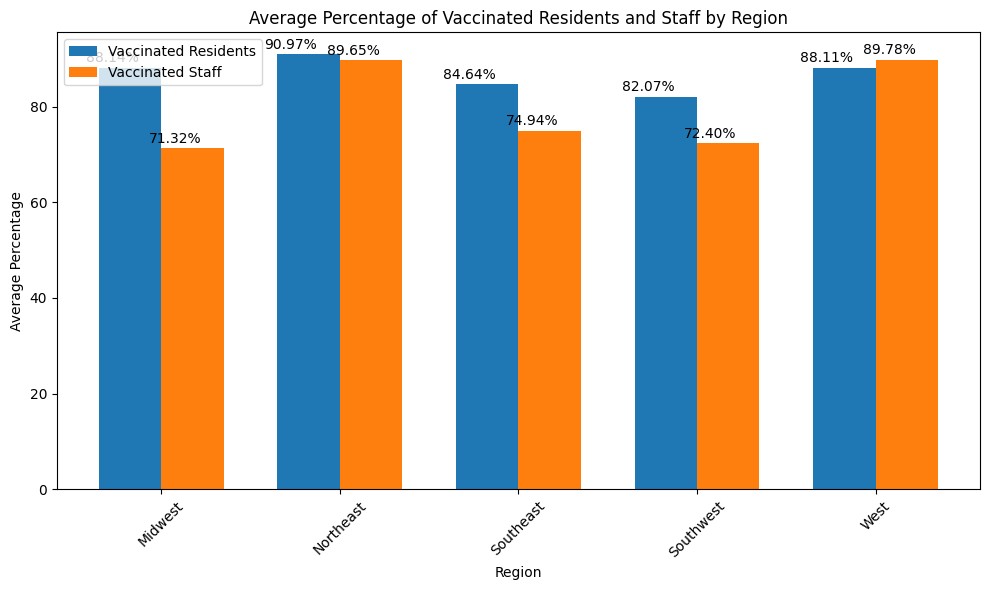

In [99]:
import matplotlib.pyplot as plt

# Replace state codes with region names
df_COVID_merged['Region'] = df_COVID_merged['STATE_CODE'].map(region_mapping)

# Group by 'Region' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each region
groupby_region_residents = df_COVID_merged.groupby('Region')['PERCENT_VAX_RES'].mean()
groupby_region_staff = df_COVID_merged.groupby('Region')['PERCENT_VAX_STAFF'].mean()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(groupby_region_residents))

bars1 = plt.bar(index, groupby_region_residents, bar_width, label='Vaccinated Residents')
bars2 = plt.bar([i + bar_width for i in index], groupby_region_staff, bar_width, label='Vaccinated Staff')

plt.xlabel('Region')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff by Region')
plt.xticks([i + bar_width / 2 for i in index], groupby_region_residents.index, rotation=45)
plt.legend()

# Adding labels to each bar
for bar in bars1 + bars2:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [100]:
from scipy.stats import f_oneway

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVIDwestStates['PERCENT_VAX_RES'], COVIDsouthwestStates['PERCENT_VAX_RES'],
                                COVIDnortheastStates['PERCENT_VAX_RES'], COVIDsoutheastStates['PERCENT_VAX_RES'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 259.5543742417148
P-value: 8.831330956680407e-162


In [101]:
# Perform ANOVA test
f_statistic, p_value = f_oneway(COVIDwestStates['PERCENT_VAX_STAFF'], COVIDsouthwestStates['PERCENT_VAX_STAFF'],
                                COVIDnortheastStates['PERCENT_VAX_STAFF'], COVIDsoutheastStates['PERCENT_VAX_STAFF'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", "{:.15f}".format(p_value))

ANOVA F-statistic: 844.1939077871256
P-value: 0.000000000000000


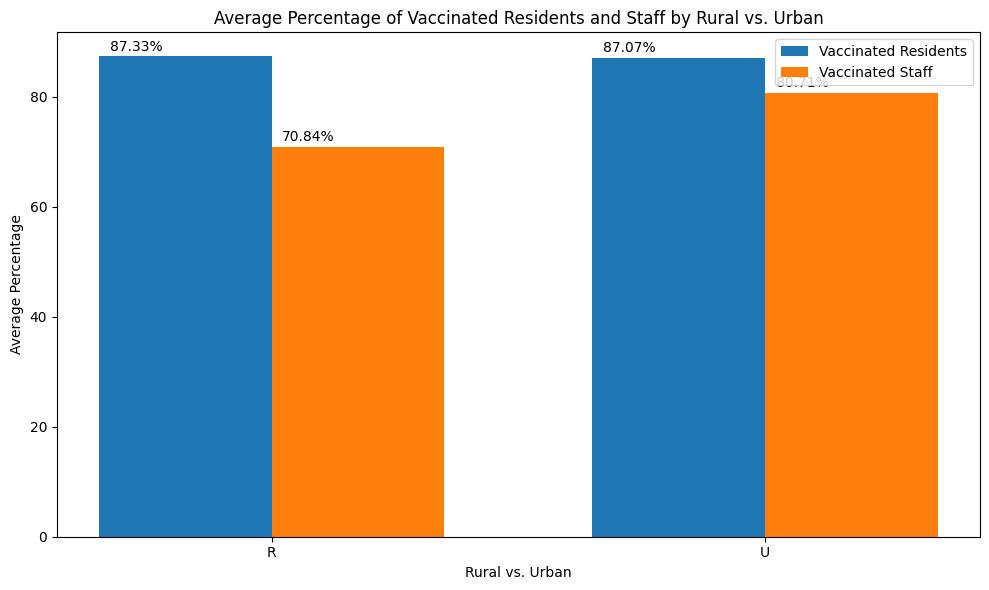

In [102]:
import matplotlib.pyplot as plt

# Group by 'RURAL_VERSUS_URBAN' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each category
groupby_rural_urban_residents = df_COVID_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_RES'].mean()
groupby_rural_urban_staff = df_COVID_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_STAFF'].mean()

# Plotting the average percent vaccinated residents and staff for each rural vs. urban category
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(groupby_rural_urban_residents))

bars1 = plt.bar(index, groupby_rural_urban_residents, bar_width, label='Vaccinated Residents')
bars2 = plt.bar([i + bar_width for i in index], groupby_rural_urban_staff, bar_width, label='Vaccinated Staff')

plt.xlabel('Rural vs. Urban')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff by Rural vs. Urban')
plt.xticks([i + bar_width / 2 for i in index], groupby_rural_urban_residents.index)
plt.legend()

# Adding labels to each bar
for bar in bars1 + bars2:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [103]:
# Separate the data into two groups based on the facility type
urban_profits = df_COVID_merged[df_COVID_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_RES']
rural_profits = df_COVID_merged[df_COVID_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_RES']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits, rural_profits, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -1.1990710209927582
P-value: 0.23052079198201816


In [104]:
# Separate the data into two groups based on the facility type
urban_profits = df_COVID_merged[df_COVID_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_STAFF']
rural_profits = df_COVID_merged[df_COVID_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_STAFF']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits, rural_profits, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 29.820787366305936
P-value: 1.8381806955855936e-189


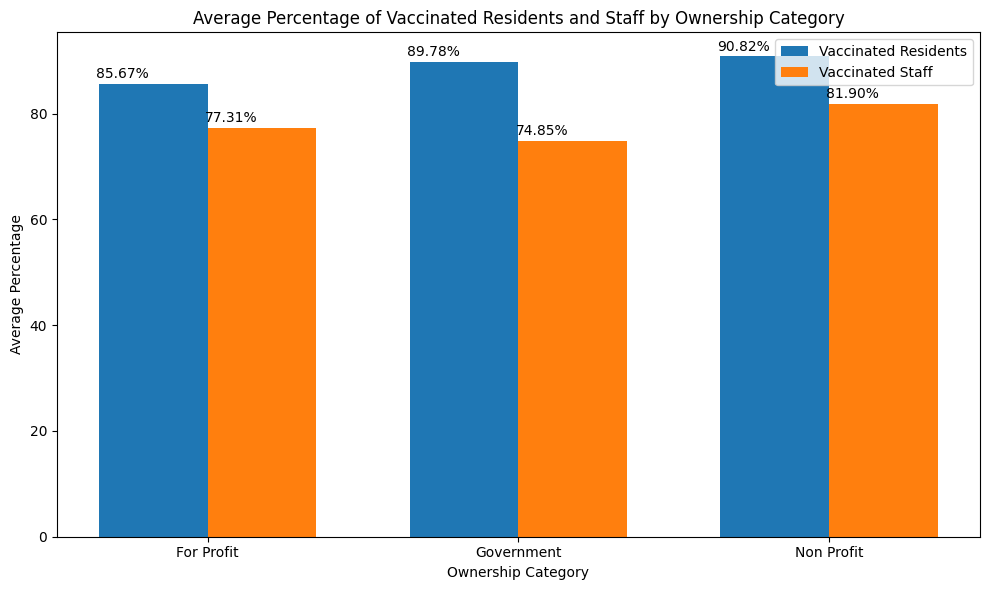

In [105]:
import matplotlib.pyplot as plt

# Mapping dictionary for ownership types
ownership_mapping = {
    'For profit - Corporation': 'For Profit',
    'For profit - Partnership': 'For Profit',
    'For profit - Individual': 'For Profit',
    'For profit - Limited Liability company': 'For Profit',
    'Non profit - Corporation': 'Non Profit',
    'Non profit - Church related': 'Non Profit',
    'Non profit - Other': 'Non Profit',
    'Government - County': 'Government',
    'Government - Hospital district': 'Government',
    'Government - State': 'Government',
    'Government - City/county': 'Government',
    'Government - City': 'Government',
    'Government - Federal': 'Government'
}

# Replace ownership types with the mapped categories
df_COVID_merged['Ownership Category'] = df_COVID_merged['OWNERSHIP'].map(ownership_mapping)

# Group by 'Ownership Category' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each category
groupby_ownership_residents = df_COVID_merged.groupby('Ownership Category')['PERCENT_VAX_RES'].mean()
groupby_ownership_staff = df_COVID_merged.groupby('Ownership Category')['PERCENT_VAX_STAFF'].mean()

# Plotting the average percent vaccinated residents and staff for each ownership type
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(groupby_ownership_residents))

bars1 = plt.bar(index, groupby_ownership_residents, bar_width, label='Vaccinated Residents')
bars2 = plt.bar([i + bar_width for i in index], groupby_ownership_staff, bar_width, label='Vaccinated Staff')

plt.xlabel('Ownership Category')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff by Ownership Category')
plt.xticks([i + bar_width / 2 for i in index], groupby_ownership_residents.index)
plt.legend()

# Adding labels to each bar
for bar in bars1 + bars2:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [106]:
COVIDfor_profit = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'For Profit - Corporation') |
                            (df_COVID_merged['OWNERSHIP'] == 'For profit - Partnership') |
                            (df_COVID_merged['OWNERSHIP'] == 'For profit - Individual') |
                            (df_COVID_merged['OWNERSHIP'] == 'For profit - Limited Liability company') |
                            (df_COVID_merged['OWNERSHIP'] == 'For profit - Partnership')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','OWNERSHIP','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF']]
COVIDnon_profit = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'Non profit - Corporation') |
                            (df_COVID_merged['OWNERSHIP'] == 'Non profit - Church related') |
                            (df_COVID_merged['OWNERSHIP'] == 'Non profit - Other')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','OWNERSHIP','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF']]
COVIDgovt_owned = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'Government - County') |
                            (df_COVID_merged['OWNERSHIP'] == 'Government - Hospital district') |
                            (df_COVID_merged['OWNERSHIP'] == 'Government - State') |
                            (df_COVID_merged['OWNERSHIP'] == 'Government - City/county') |
                            (df_COVID_merged['OWNERSHIP'] == 'Government - City') |
                            (df_COVID_merged['OWNERSHIP'] == 'Government - Federal')&(ownershipMerge['NET_INCOME'].notnull())][['PROVNUM','OWNERSHIP','NET_INCOME','PERCENT_VAX_RES','PERCENT_VAX_STAFF']]

<ipython-input-106-63f56e823706>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  COVIDfor_profit = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'For Profit - Corporation') |
<ipython-input-106-63f56e823706>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  COVIDnon_profit = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'Non profit - Corporation') |
<ipython-input-106-63f56e823706>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  COVIDgovt_owned = df_COVID_merged[(df_COVID_merged['OWNERSHIP'] == 'Government - County') |


In [107]:
# Handle null values for each filtered dataset
COVIDfor_profit_clean = COVIDfor_profit.dropna(subset=['PERCENT_VAX_RES'])
COVIDnon_profit_clean = COVIDnon_profit.dropna(subset=['PERCENT_VAX_RES'])
COVIDgovt_owned_clean = COVIDgovt_owned.dropna(subset=['PERCENT_VAX_RES'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVIDfor_profit_clean['PERCENT_VAX_RES'],
                                COVIDnon_profit_clean['PERCENT_VAX_RES'],
                                COVIDgovt_owned_clean['PERCENT_VAX_RES'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 196.413823289386
P-value: 6.781166871537615e-84


In [108]:
# Handle null values for each filtered dataset
COVIDfor_profit_clean = COVIDfor_profit.dropna(subset=['PERCENT_VAX_STAFF'])
COVIDnon_profit_clean = COVIDnon_profit.dropna(subset=['PERCENT_VAX_STAFF'])
COVIDgovt_owned_clean = COVIDgovt_owned.dropna(subset=['PERCENT_VAX_STAFF'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVIDfor_profit_clean['PERCENT_VAX_STAFF'],
                                COVIDnon_profit_clean['PERCENT_VAX_STAFF'],
                                COVIDgovt_owned_clean['PERCENT_VAX_STAFF'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 77.85111957539125
P-value: 3.3980892338489846e-34


## **🔹 COVID 2022 Data**

In [109]:
df_COVID22 = pd.read_csv('CovidVax_2022.csv')

In [110]:
print(df_COVID22.columns)

Index(['Federal Provider Number', 'Provider State',
       'Percent of residents who completed primary vaccination series',
       'Percent of staff who completed primary vaccination series',
       'Percent of residents who are up-to-date on their vaccines',
       'Percent of staff who are up-to-date on their vaccines',
       'Date vaccination data last updated'],
      dtype='object')


In [111]:
column_mapping = {
    'Federal Provider Number': 'PROVNUM',
    'Percent of residents who completed primary vaccination series':'PERCENT_VAX_RES_PRIMARY',
    'Percent of staff who completed primary vaccination series' : 'PERCENT_VAX_STAFF_PRIMARY',
    'Percent of residents who are up-to-date on their vaccines':'PERCENT_VAX_RES_UP2DATE',
    'Percent of staff who are up-to-date on their vaccines' : 'PERCENT_VAX_STAFF_UP2DATE',
    'Provider State': 'STATE_CODE'}

# Rename the columns
df_COVID22.rename(columns=column_mapping, inplace=True)

In [112]:
df_COVID22.head()

,PROVNUM,STATE_CODE,PERCENT_VAX_RES_PRIMARY,PERCENT_VAX_STAFF_PRIMARY,PERCENT_VAX_RES_UP2DATE,PERCENT_VAX_STAFF_UP2DATE,Date vaccination data last updated
0,015009,AL,92.5,86.4,88.7,29.6,10/16/2022
1,015010,AL,89.3,77.7,65.3,0.0,10/16/2022
2,015012,AL,100.0,91.6,92.1,3.6,10/16/2022
3,015014,AL,95.0,97.0,83.8,69.3,10/16/2022
4,015015,AL,94.4,83.6,24.7,8.2,10/16/2022


In [113]:
df_COVID22['PROVNUM'] = df_COVID22['PROVNUM'].astype(str).str.lstrip('0')


In [114]:
# Merge df_COVID with df_COSTclean to add 'RURAL_VERSUS_URBAN'
df_COVID22_merged = pd.merge(df_COVID22, df_COSTclean[['PROVNUM', 'RURAL_VERSUS_URBAN']], on='PROVNUM', how='left')

# Merge df_COVID_merged with df_PROVIDERclean to add 'OWNERSHIP'
df_COVID22_merged = pd.merge(df_COVID22_merged, df_PROVIDERclean[['PROVNUM', 'OWNERSHIP']], on='PROVNUM', how='left')


In [115]:
# Replace 'Not Available' with NaN
df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'].astype(float)

# Replace 'Not Available' with NaN
df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'].astype(float)

# Replace 'Not Available' with NaN
df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'].astype(float)

# Replace 'Not Available' with NaN
df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'].replace('Not Available', np.nan)

# Convert the column to float
df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'].astype(float)

# Check the data types after conversion
print(df_COVID22_merged.dtypes)

PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES_PRIMARY               float64
PERCENT_VAX_STAFF_PRIMARY             float64
PERCENT_VAX_RES_UP2DATE               float64
PERCENT_VAX_STAFF_UP2DATE             float64
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
dtype: object


In [116]:
# Group by 'PROVNUM' and select the last value of each column
df_COVID22_merged = df_COVID22_merged.groupby('PROVNUM').last()

# Reset the index to make 'PROVNUM' a regular column
df_COVID22_merged.reset_index(inplace=True)

In [117]:
# Convert columns to the desired data types
df_COVID22_merged['PROVNUM'] = df_COVID22_merged['PROVNUM'].astype(str)
df_COVID22_merged['STATE_CODE'] = df_COVID22_merged['STATE_CODE'].astype(str)
df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_RES_PRIMARY'].astype(float)
df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'] = df_COVID22_merged['PERCENT_VAX_STAFF_PRIMARY'].astype(float)
df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_RES_UP2DATE'].astype(float)
df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'] = df_COVID22_merged['PERCENT_VAX_STAFF_UP2DATE'].astype(float)
# Check the data types after conversion
print(df_COVID22_merged.dtypes)

PROVNUM                                object
STATE_CODE                             object
PERCENT_VAX_RES_PRIMARY               float64
PERCENT_VAX_STAFF_PRIMARY             float64
PERCENT_VAX_RES_UP2DATE               float64
PERCENT_VAX_STAFF_UP2DATE             float64
Date vaccination data last updated     object
RURAL_VERSUS_URBAN                     object
OWNERSHIP                              object
dtype: object


In [118]:
COVID22westStates = df_COVID22_merged[(df_COVID22_merged['STATE_CODE'] == 'CA') |(df_COVID22_merged['STATE_CODE'] == 'OR') |(df_COVID22_merged['STATE_CODE'] == 'WA') |(df_COVID22_merged['STATE_CODE'] == 'NV') |
                                  (df_COVID22_merged['STATE_CODE'] == 'ID') |(df_COVID22_merged['STATE_CODE'] == 'MT') |
                                  (df_COVID22_merged['STATE_CODE'] == 'WY') |(df_COVID22_merged['STATE_CODE'] == 'UT') |
                                  (df_COVID22_merged['STATE_CODE'] == 'CO')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY',
                                                                              'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]


COVID22midwestStates = df_COVID22_merged[(df_COVID22_merged['STATE_CODE'] == 'ND') |(df_COVID22_merged['STATE_CODE'] == 'SD') |
                                  (df_COVID22_merged['STATE_CODE'] == 'NE') |(df_COVID22_merged['STATE_CODE'] == 'KS') |
                                  (df_COVID22_merged['STATE_CODE'] == 'MN') |(df_COVID22_merged['STATE_CODE'] == 'IA') |
                                  (df_COVID22_merged['STATE_CODE'] == 'MO') |(df_COVID22_merged['STATE_CODE'] == 'WI') |
                                  (df_COVID22_merged['STATE_CODE'] == 'IL') |(df_COVID22_merged['STATE_CODE'] == 'IN') |
                                  (df_COVID22_merged['STATE_CODE'] == 'MI') |(df_COVID22_merged['STATE_CODE'] == 'OH')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY','PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]



COVID22southwestStates = df_COVID22_merged[(df_COVID22_merged['STATE_CODE'] == 'AZ') |(df_COVID22_merged['STATE_CODE'] == 'NM') |(df_COVID22_merged['STATE_CODE'] == 'OK') |(df_COVID22_merged['STATE_CODE'] == 'TX')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY','PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]

COVID22northeastStates = df_COVID22_merged[(df_COVID22_merged['STATE_CODE'] == 'PA') |(df_COVID22_merged['STATE_CODE'] == 'NY') |(df_COVID22_merged['STATE_CODE'] == 'VT') |(df_COVID22_merged['STATE_CODE'] == 'ME') |
                                  (df_COVID22_merged['STATE_CODE'] == 'NH') |(df_COVID22_merged['STATE_CODE'] == 'MA') |
                                  (df_COVID22_merged['STATE_CODE'] == 'CT') |(df_COVID22_merged['STATE_CODE'] == 'RI') |
                                  (df_COVID22_merged['STATE_CODE'] == 'NJ') |(df_COVID22_merged['STATE_CODE'] == 'DE') |(df_COVID22_merged['STATE_CODE'] == 'MD')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY',
                                     'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]

COVID22southeastStates = df_COVID22_merged[(df_COVID22_merged['STATE_CODE'] == 'AR') |(df_COVID22_merged['STATE_CODE'] == 'LA') |(df_COVID22_merged['STATE_CODE'] == 'MS') |(df_COVID22_merged['STATE_CODE'] == 'TN') |
                                  (df_COVID22_merged['STATE_CODE'] == 'KY') |(df_COVID22_merged['STATE_CODE'] == 'AL') |
                                  (df_COVID22_merged['STATE_CODE'] == 'WV') |(df_COVID22_merged['STATE_CODE'] == 'VA') |(df_COVID22_merged['STATE_CODE'] == 'FL')|
                                  (df_COVID22_merged['STATE_CODE'] == 'NC') |(df_COVID22_merged['STATE_CODE'] == 'SC') |(df_COVID22_merged['STATE_CODE'] == 'GA')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY',
                                                                              'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]

In [119]:
# Calculate percentage of null records for each DataFrame
null_percentage_west22 = calculate_null_percentage(COVID22westStates)
null_percentage_southwest22 = calculate_null_percentage(COVID22southwestStates)
null_percentage_northeast22 = calculate_null_percentage(COVID22northeastStates)
null_percentage_southeast22 = calculate_null_percentage(COVID22southeastStates)

# Display the results
print("Percentage of null records in COVID22westStates:")
print(null_percentage_west22)
print()

print("Percentage of null records in COVID22southwestStates:")
print(null_percentage_southwest22)
print()

print("Percentage of null records in COVID22northeastStates:")
print(null_percentage_northeast22)
print()

print("Percentage of null records in COVID22southeastStates:")
print(null_percentage_southeast22)

Percentage of null records in COVID22westStates:
PROVNUM                      0.00
STATE_CODE                   0.00
PERCENT_VAX_RES_PRIMARY      3.76
PERCENT_VAX_STAFF_PRIMARY    3.85
PERCENT_VAX_RES_UP2DATE      3.76
PERCENT_VAX_STAFF_UP2DATE    3.85
RURAL_VERSUS_URBAN          10.83
OWNERSHIP                    2.31
dtype: float64

Percentage of null records in COVID22southwestStates:
PROVNUM                     0.00
STATE_CODE                  0.00
PERCENT_VAX_RES_PRIMARY     2.63
PERCENT_VAX_STAFF_PRIMARY   2.45
PERCENT_VAX_RES_UP2DATE     2.63
PERCENT_VAX_STAFF_UP2DATE   2.45
RURAL_VERSUS_URBAN          3.21
OWNERSHIP                   0.93
dtype: float64

Percentage of null records in COVID22northeastStates:
PROVNUM                     0.00
STATE_CODE                  0.00
PERCENT_VAX_RES_PRIMARY     2.36
PERCENT_VAX_STAFF_PRIMARY   2.25
PERCENT_VAX_RES_UP2DATE     2.36
PERCENT_VAX_STAFF_UP2DATE   2.25
RURAL_VERSUS_URBAN          5.41
OWNERSHIP                   0.33
dtype: floa

In [120]:
# Drop records with null values in COVIDwestStates
COVID22westStates.dropna(inplace=True)

# Drop records with null values in COVIDmidwestStates
COVID22midwestStates.dropna(inplace=True)

# Drop records with null values in COVIDsouthwestStates
COVID22southwestStates.dropna(inplace=True)

# Drop records with null values in COVIDnortheastStates
COVID22northeastStates.dropna(inplace=True)

# Drop records with null values in COVIDsoutheastStates
COVID22southeastStates.dropna(inplace=True)

In [121]:
# Handle null values for each filtered dataset
COVID22westStates = COVID22westStates.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22midwestStates = COVID22midwestStates.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22southwestStates = COVID22southwestStates.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22northeastStates = COVID22northeastStates.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22southeastStates = COVID22southeastStates.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22westStates['PERCENT_VAX_RES_PRIMARY'],
                                COVID22midwestStates['PERCENT_VAX_RES_PRIMARY'],
                                COVID22southwestStates['PERCENT_VAX_RES_PRIMARY'],
                                COVID22northeastStates['PERCENT_VAX_RES_PRIMARY'],
                                COVID22southeastStates['PERCENT_VAX_RES_PRIMARY'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 266.6510480019307
P-value: 4.589841861977758e-221


In [122]:
# Handle null values for each filtered dataset
COVID22westStates = COVID22westStates.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22midwestStates = COVID22midwestStates.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22southwestStates = COVID22southwestStates.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22northeastStates = COVID22northeastStates.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22southeastStates = COVID22southeastStates.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22westStates['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22midwestStates['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22southwestStates['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22northeastStates['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22southeastStates['PERCENT_VAX_STAFF_PRIMARY'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 609.1867891857246
P-value: 0.0


In [123]:
# Handle null values for each filtered dataset
COVID22westStates = COVID22westStates.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22midwestStates = COVID22midwestStates.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22southwestStates = COVID22southwestStates.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22northeastStates = COVID22northeastStates.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22southeastStates = COVID22southeastStates.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22westStates['PERCENT_VAX_RES_UP2DATE'],
                                COVID22midwestStates['PERCENT_VAX_RES_UP2DATE'],
                                COVID22southwestStates['PERCENT_VAX_RES_UP2DATE'],
                                COVID22northeastStates['PERCENT_VAX_RES_UP2DATE'],
                                COVID22southeastStates['PERCENT_VAX_RES_UP2DATE'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 52.858943010384436
P-value: 2.8824801629376024e-44


In [124]:
# Handle null values for each filtered dataset
COVID22westStates = COVID22westStates.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22midwestStates = COVID22midwestStates.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22southwestStates = COVID22southwestStates.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22northeastStates = COVID22northeastStates.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22southeastStates = COVID22southeastStates.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22westStates['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22midwestStates['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22southwestStates['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22northeastStates['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22southeastStates['PERCENT_VAX_STAFF_UP2DATE'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 271.09448242820304
P-value: 1.230114814239111e-224


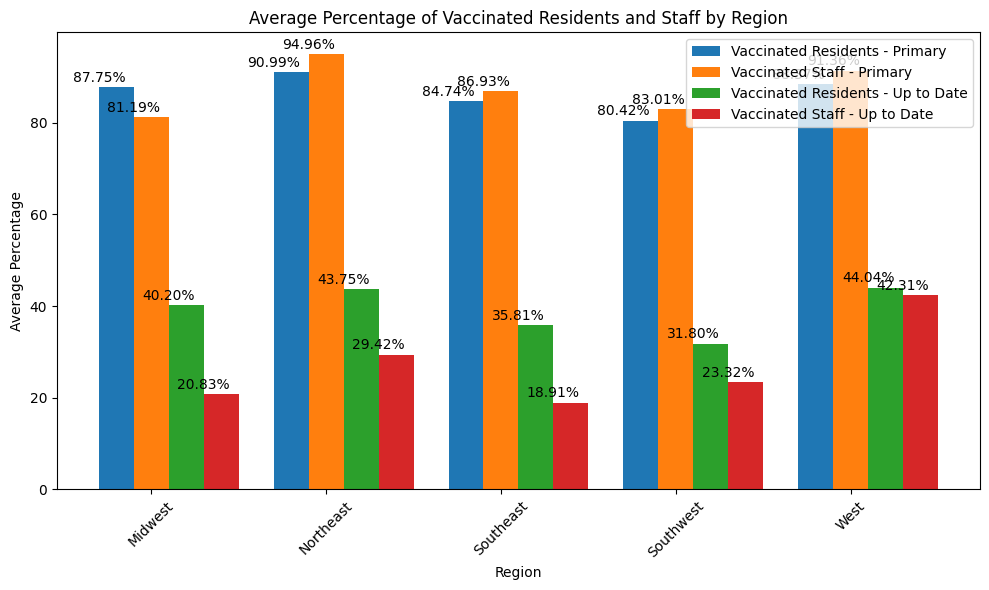

In [125]:
# Replace state codes with region names
df_COVID22_merged['Region'] = df_COVID22_merged['STATE_CODE'].map(region_mapping)

# Group by 'Region' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each region
groupby_region_residentsP = df_COVID22_merged.groupby('Region')['PERCENT_VAX_RES_PRIMARY'].mean()
groupby_region_staffP = df_COVID22_merged.groupby('Region')['PERCENT_VAX_STAFF_PRIMARY'].mean()
groupby_region_residentsU2D = df_COVID22_merged.groupby('Region')['PERCENT_VAX_RES_UP2DATE'].mean()
groupby_region_staffU2D = df_COVID22_merged.groupby('Region')['PERCENT_VAX_STAFF_UP2DATE'].mean()

# Convert range object to a list
index = list(range(len(groupby_region_residentsP)))

# Plotting the average percent vaccinated residents and staff for each region
plt.figure(figsize=(10, 6))
bar_width = 0.2

bars1 = plt.bar(np.array(index) - bar_width, groupby_region_residentsP, bar_width, label='Vaccinated Residents - Primary')
bars2 = plt.bar(index, groupby_region_staffP, bar_width, label='Vaccinated Staff - Primary')
bars3 = plt.bar(np.array(index) + bar_width, groupby_region_residentsU2D, bar_width, label='Vaccinated Residents - Up to Date')
bars4 = plt.bar(np.array(index) + 2*bar_width, groupby_region_staffU2D, bar_width, label='Vaccinated Staff - Up to Date')

plt.xlabel('Region')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff by Region')
plt.xticks(index, groupby_region_residentsP.index, rotation=45)
plt.legend()

# Adding labels to each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

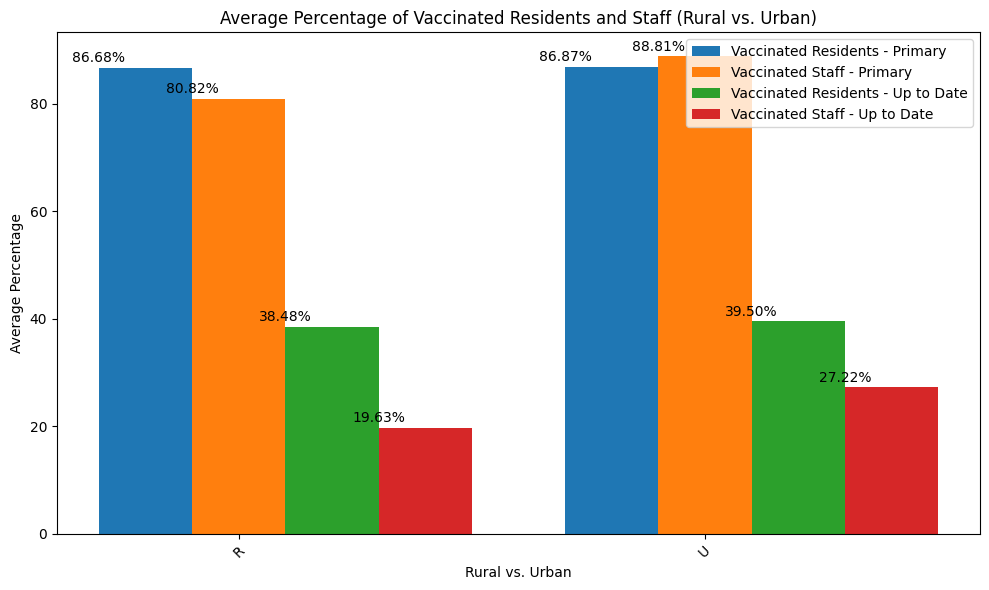

In [126]:
# Group by 'RURAL_VERSUS_URBAN' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each category
groupby_rural_urban_residentsP = df_COVID22_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_RES_PRIMARY'].mean()
groupby_rural_urban_staffP = df_COVID22_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_STAFF_PRIMARY'].mean()
groupby_rural_urban_residentsU2D = df_COVID22_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_RES_UP2DATE'].mean()
groupby_rural_urban_staffU2D = df_COVID22_merged.groupby('RURAL_VERSUS_URBAN')['PERCENT_VAX_STAFF_UP2DATE'].mean()

# Convert range object to a list
index = list(range(len(groupby_rural_urban_residentsP)))

# Plotting the average percent vaccinated residents and staff for each region
plt.figure(figsize=(10, 6))
bar_width = 0.2

bars1 = plt.bar(np.array(index) - bar_width, groupby_rural_urban_residentsP, bar_width, label='Vaccinated Residents - Primary')
bars2 = plt.bar(index, groupby_rural_urban_staffP, bar_width, label='Vaccinated Staff - Primary')
bars3 = plt.bar(np.array(index) + bar_width, groupby_rural_urban_residentsU2D, bar_width, label='Vaccinated Residents - Up to Date')
bars4 = plt.bar(np.array(index) + 2*bar_width, groupby_rural_urban_staffU2D, bar_width, label='Vaccinated Staff - Up to Date')

plt.xlabel('Rural vs. Urban')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff (Rural vs. Urban)')
plt.xticks(index, groupby_rural_urban_residentsP.index, rotation=45)
plt.legend()

# Adding labels to each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [127]:
# Separate the data into two groups based on the facility type
urban_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_RES_PRIMARY']
rural_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_RES_PRIMARY']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits22, rural_profits22, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.8395658583400141
P-value: 0.4011664211257219


In [128]:
# Separate the data into two groups based on the facility type
urban_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_RES_UP2DATE']
rural_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_RES_UP2DATE']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits22, rural_profits22, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 1.5880052778401537
P-value: 0.11230810004508028


In [129]:
# Separate the data into two groups based on the facility type
urban_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_STAFF_PRIMARY']
rural_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_STAFF_PRIMARY']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits22, rural_profits22, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 31.416357198769315
P-value: 2.6935116611142226e-209


In [130]:
# Separate the data into two groups based on the facility type
urban_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'U']['PERCENT_VAX_STAFF_UP2DATE']
rural_profits22 = df_COVID22_merged[df_COVID22_merged['RURAL_VERSUS_URBAN'] == 'R']['PERCENT_VAX_STAFF_UP2DATE']

# Perform the t-test
t_statistic, p_value = ttest_ind(urban_profits22, rural_profits22, nan_policy='omit')

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 13.704728625827471
P-value: 1.8065852693390734e-42


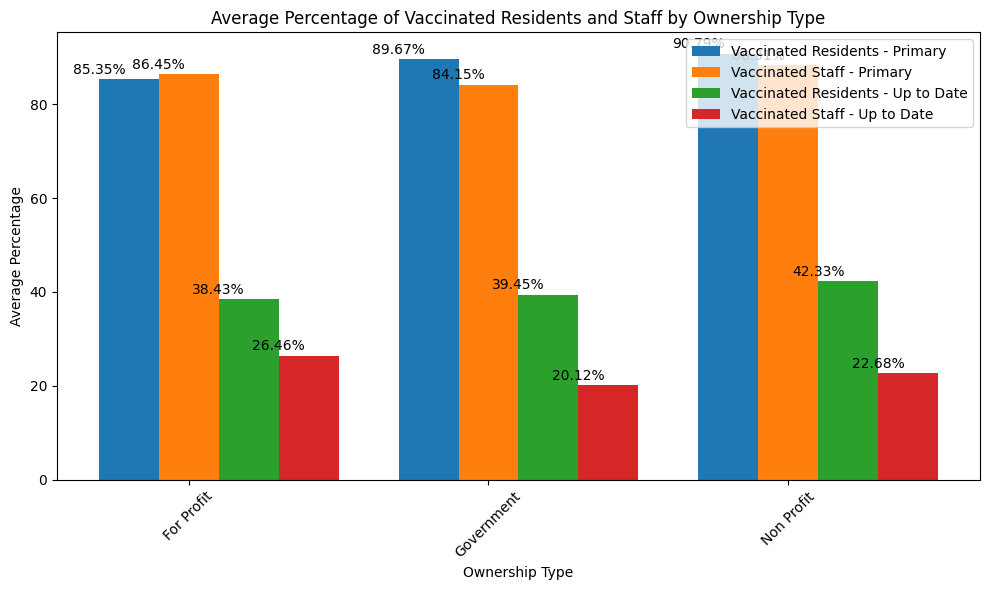

In [131]:
# Replace ownership types with the mapped categories
df_COVID22_merged['Ownership Category'] = df_COVID22_merged['OWNERSHIP'].map(ownership_mapping)

# Group by 'Ownership Category' and calculate average of 'PERCENT_VAX_RES' and 'PERCENT_VAX_STAFF' for each category
groupby_ownership_residentsP = df_COVID22_merged.groupby('Ownership Category')['PERCENT_VAX_RES_PRIMARY'].mean()
groupby_ownership_staffP = df_COVID22_merged.groupby('Ownership Category')['PERCENT_VAX_STAFF_PRIMARY'].mean()
groupby_ownership_residentsU2D = df_COVID22_merged.groupby('Ownership Category')['PERCENT_VAX_RES_UP2DATE'].mean()
groupby_ownership_staffU2D = df_COVID22_merged.groupby('Ownership Category')['PERCENT_VAX_STAFF_UP2DATE'].mean()

# Convert range object to a list
index = list(range(len(groupby_ownership_residentsP)))

# Plotting the average percent vaccinated residents and staff for each region
plt.figure(figsize=(10, 6))
bar_width = 0.2

bars1 = plt.bar(np.array(index) - bar_width, groupby_ownership_residentsP, bar_width, label='Vaccinated Residents - Primary')
bars2 = plt.bar(index, groupby_ownership_staffP, bar_width, label='Vaccinated Staff - Primary')
bars3 = plt.bar(np.array(index) + bar_width, groupby_ownership_residentsU2D, bar_width, label='Vaccinated Residents - Up to Date')
bars4 = plt.bar(np.array(index) + 2*bar_width, groupby_ownership_staffU2D, bar_width, label='Vaccinated Staff - Up to Date')

plt.xlabel('Ownership Type')
plt.ylabel('Average Percentage')
plt.title('Average Percentage of Vaccinated Residents and Staff by Ownership Type')
plt.xticks(index, groupby_ownership_residentsP.index, rotation=45)
plt.legend()

# Adding labels to each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, '{:.2f}%'.format(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [132]:
COVID22for_profit = df_COVID22_merged[(df_COVID22_merged['OWNERSHIP'] == 'For Profit - Corporation') |
                            (df_COVID22_merged['OWNERSHIP'] == 'For profit - Partnership') |
                            (df_COVID22_merged['OWNERSHIP'] == 'For profit - Individual') |
                            (df_COVID22_merged['OWNERSHIP'] == 'For profit - Limited Liability company') |
                            (df_COVID22_merged['OWNERSHIP'] == 'For profit - Partnership')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY', 'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]
COVID22non_profit = df_COVID22_merged[(df_COVID22_merged['OWNERSHIP'] == 'Non profit - Corporation') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Non profit - Church related') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Non profit - Other')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY', 'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]
COVID22govt_owned = df_COVID22_merged[(df_COVID22_merged['OWNERSHIP'] == 'Government - County') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Government - Hospital district') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Government - State') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Government - City/county') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Government - City') |
                            (df_COVID22_merged['OWNERSHIP'] == 'Government - Federal')][['PROVNUM','STATE_CODE','PERCENT_VAX_RES_PRIMARY','PERCENT_VAX_STAFF_PRIMARY', 'PERCENT_VAX_RES_UP2DATE','PERCENT_VAX_STAFF_UP2DATE','RURAL_VERSUS_URBAN','OWNERSHIP']]

In [133]:
# Handle null values for each filtered dataset
COVID22for_profit_clean = COVID22for_profit.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22non_profit_clean = COVID22non_profit.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])
COVID22govt_owned_clean = COVID22govt_owned.dropna(subset=['PERCENT_VAX_RES_PRIMARY'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22for_profit_clean['PERCENT_VAX_RES_PRIMARY'],
                                COVID22non_profit_clean['PERCENT_VAX_RES_PRIMARY'],
                                COVID22govt_owned_clean['PERCENT_VAX_RES_PRIMARY'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 212.3415878019432
P-value: 1.9694784779453387e-90


In [134]:
# Handle null values for each filtered dataset
COVID22for_profit_clean = COVID22for_profit.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22non_profit_clean = COVID22non_profit.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])
COVID22govt_owned_clean = COVID22govt_owned.dropna(subset=['PERCENT_VAX_STAFF_PRIMARY'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22for_profit_clean['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22non_profit_clean['PERCENT_VAX_STAFF_PRIMARY'],
                                COVID22govt_owned_clean['PERCENT_VAX_STAFF_PRIMARY'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 34.16257472336089
P-value: 1.7000695404666248e-15


In [135]:
# Handle null values for each filtered dataset
COVID22for_profit_clean = COVID22for_profit.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22non_profit_clean = COVID22non_profit.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])
COVID22govt_owned_clean = COVID22govt_owned.dropna(subset=['PERCENT_VAX_RES_UP2DATE'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22for_profit_clean['PERCENT_VAX_RES_UP2DATE'],
                                COVID22non_profit_clean['PERCENT_VAX_RES_UP2DATE'],
                                COVID22govt_owned_clean['PERCENT_VAX_RES_UP2DATE'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 5.111662134075764
P-value: 0.006047042020594677


In [136]:
# Handle null values for each filtered dataset
COVID22for_profit_clean = COVID22for_profit.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22non_profit_clean = COVID22non_profit.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])
COVID22govt_owned_clean = COVID22govt_owned.dropna(subset=['PERCENT_VAX_STAFF_UP2DATE'])

# Perform ANOVA test
f_statistic, p_value = f_oneway(COVID22for_profit_clean['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22non_profit_clean['PERCENT_VAX_STAFF_UP2DATE'],
                                COVID22govt_owned_clean['PERCENT_VAX_STAFF_UP2DATE'])
print("ANOVA F-statistic:", f_statistic)
print("P-value:", p_value)

ANOVA F-statistic: 63.382060776603915
P-value: 5.049566516311095e-28


# **MODELS**

In [137]:
print(df_COSTclean.columns)

Index(['RPT_REC_NUM', 'PROVNUM', 'FACILITY_NAME', 'STREET_ADDRESS', 'CITY',
       'STATE_CODE', 'ZIP_CODE', 'COUNTY', 'MEDICARE_CBSA_NUMBER',
       'RURAL_VERSUS_URBAN', 'FISCAL_YEAR_BEGIN_DATE', 'FISCAL_YEAR_END_DATE',
       'TYPE_OF_CONTROL', 'ACCOUNTS_RECEIVABLE', 'ACCOUNTS_PAYABLE',
       'CASH_ON_HAND_AND_IN_BANKS', 'GENERAL_FUND_BALANCE', 'GROSS_REVENUE',
       'INPATIENT_PPS_AMOUNT', 'INPATIENT_REVENUE',
       'LESS_TOTAL_OPERATING_EXPENSE', 'LESS_DISCOUNTS_ON_PATIENTS',
       'MAJOR_MOVABLE_EQUIPMENT', 'NET_INCOME', 'NET_INCOME_FROM_PATIENTS',
       'NET_PATIENT_REVENUE', 'NUMBER_OF_BEDS', 'OTHER_ASSETS',
       'OTHER_CURRENT_LIABILITIES', 'OVERHEAD_NON_SALARY_COSTS',
       'SNF_ADMISSIONS_OTHER', 'SNF_ADMISSIONS_TITLE_XIX',
       'SNF_ADMISSIONS_TITLE_XVIII', 'SNF_ADMISSIONS_TOTAL',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOT', 'SNF_AVERAGE_LENGTH_STAY_XIX',
       'SNF_AVERAGE_LENGTH_STAY_XVIII', 'SNF_DAYS_OTHER', 'SNF_DAYS_TITLE_XIX',
       'SNF_DAYS_TITLE_XVIII', 'SN

In [138]:
print(df_PROVIDERclean.columns)

Index(['PROVNUM', 'ZIP', 'PHONE', 'COUNTY_SSA', 'BEDCERT', 'RESTOT',
       'OVERALL_RATING', 'SURVEY_RATING', 'QUALITY_RATING', 'STAFFING_RATING',
       'RN_STAFFING_RATING', 'AIDHRD', 'VOCHRD', 'RNHRD', 'TOTLICHRD',
       'TOTHRD', 'PTHRD', 'EXP_AIDE', 'EXP_LPN', 'EXP_RN', 'EXP_TOTAL',
       'ADJ_AIDE', 'ADJ_LPN', 'ADJ_RN', 'ADJ_TOTAL', 'INCIDENT_CNT',
       'CMPLNT_CNT', 'FINE_CNT', 'FINE_TOT', 'PAYDEN_CNT', 'TOT_PENLTY_CNT',
       'YEAR', 'PROVNAME', 'ADDRESS', 'CITY', 'STATE', 'COUNTY_NAME',
       'OWNERSHIP', 'CERTIFICATION', 'INHOSP', 'LBN', 'PARTICIPATION_DATE',
       'CCRC_FACIL', 'SFF', 'CHOW_LAST_12MOS', 'RESFAMCOUNCIL',
       'SPRINKLER_STATUS', 'CYCLE_1_DEFS', 'CYCLE_1_NFROMDEFS',
       'CYCLE_1_NFROMCOMP', 'CYCLE_1_DEFS_SCORE', 'CYCLE_1_SURVEY_DATE',
       'CYCLE_1_NUMREVIS', 'CYCLE_1_REVISIT_SCORE', 'CYCLE_1_TOTAL_SCORE',
       'CYCLE_2_DEFS', 'CYCLE_2_NFROMDEFS', 'CYCLE_2_NFROMCOMP',
       'CYCLE_2_DEFS_SCORE', 'CYCLE_2_SURVEY_DATE', 'CYCLE_2_NUMREVIS',
    

In [139]:
print(df_PENALTYclean.columns)

Index(['PROVNUM', 'PROVNAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PNLTY_DATE',
       'PNLTY_TYPE', 'FINE_AMT', 'FILEDATE', 'YEAR'],
      dtype='object')


In [140]:
df_fine_total = df_PENALTYclean.groupby(['PROVNUM', 'YEAR']).agg({'FINE_AMT': 'sum', 'PNLTY_TYPE': 'count'}).reset_index()
df_fine_total.rename(columns={'PNLTY_TYPE': 'PNLTY_TYPE_COUNT'}, inplace=True)
df_fine_total.head()

,PROVNUM,YEAR,FINE_AMT,PNLTY_TYPE_COUNT
0,01A193,2021,2925.00,3
1,05A021,2021,9750.00,1
2,05A134,2021,650.00,1
3,05A147,2021,650.00,1
4,05A183,2021,4550.00,4


In [141]:
df_filtered_COSTclean = df_COSTclean.loc[:, ['PROVNUM', 'YEAR','STATE_CODE', 'NET_INCOME', 'RURAL_VERSUS_URBAN']]

In [201]:
# To account for providers who have more than one record per year: Group by PROVNUM and YEAR, and sum the net income
df_NETINCOME_sum = df_filtered_COSTclean.groupby(['PROVNUM', 'YEAR','STATE_CODE','RURAL_VERSUS_URBAN'])['NET_INCOME'].sum().reset_index()

# Merge df_COVID with df_COSTclean to add 'RURAL_VERSUS_URBAN'
df_modelMerge = pd.merge(df_NETINCOME_sum, df_PROVIDERclean[['PROVNUM', 'OWNERSHIP','OVERALL_RATING']], on='PROVNUM', how='left')

# Merge df_COVID_merged with df_PROVIDERclean to add 'OWNERSHIP'
df_modelMerge = pd.merge(df_modelMerge, df_fine_total, on=['PROVNUM', 'YEAR'], how='left')


In [202]:
df_modelMerge['FINE_AMT'] = df_modelMerge['FINE_AMT'].fillna(0)
df_modelMerge['PNLTY_TYPE_COUNT'] = df_modelMerge['PNLTY_TYPE_COUNT'].fillna(0)

In [203]:
df_modelMerge['Region'] = df_modelMerge['STATE_CODE'].map(region_mapping)
df_modelMerge['Ownership Category'] = df_modelMerge['OWNERSHIP'].map(ownership_mapping)


In [204]:
df_modelMerge.head(10)

,PROVNUM,YEAR,STATE_CODE,RURAL_VERSUS_URBAN,NET_INCOME,OWNERSHIP,OVERALL_RATING,FINE_AMT,PNLTY_TYPE_COUNT,Region,Ownership Category
0,105001,2015,FL,U,1537579.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
1,105001,2016,FL,U,-137595.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
2,105001,2017,FL,U,-23464.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
3,105001,2018,FL,U,-509438.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
4,105001,2019,FL,U,-299886.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
5,105001,2020,FL,U,-270551.00,For profit - Corporation,3.71,0.00,0.00,Southeast,For Profit
6,105001,2021,FL,U,-1782943.00,For profit - Corporation,3.71,5000.00,1.00,Southeast,For Profit
7,105002,2015,FL,U,270030.00,For profit - Corporation,1.71,0.00,0.00,Southeast,For Profit
8,105002,2016,FL,U,238366.00,For profit - Corporation,1.71,0.00,0.00,Southeast,For Profit
9,105002,2017,FL,U,-951025.00,For profit - Corporation,1.71,0.00,1.00,Southeast,For Profit


In [205]:
print(df_modelMerge['Ownership Category'].isnull().sum())

36


In [206]:
df_modelMerge.shape

(99338, 11)

### **🔹 Linear Regression: Ownership Category, Rural vs. Urban, Overall Rating, Region, Fine Amount, Penalty Count, Year**

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


categorical_cols = ['Ownership Category', 'RURAL_VERSUS_URBAN','OVERALL_RATING','Region','YEAR']
numerical_cols = ['FINE_AMT', 'PNLTY_TYPE_COUNT']

# Handle missing values and encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
X_cat_encoded = encoder.fit_transform(df_modelMerge[categorical_cols])
X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X = pd.concat([X_cat_df, df_modelMerge[numerical_cols]], axis=1)


y = df_modelMerge['NET_INCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)


Mean Squared Error: 990559039156.9904
R-squared: 0.04849511681692231


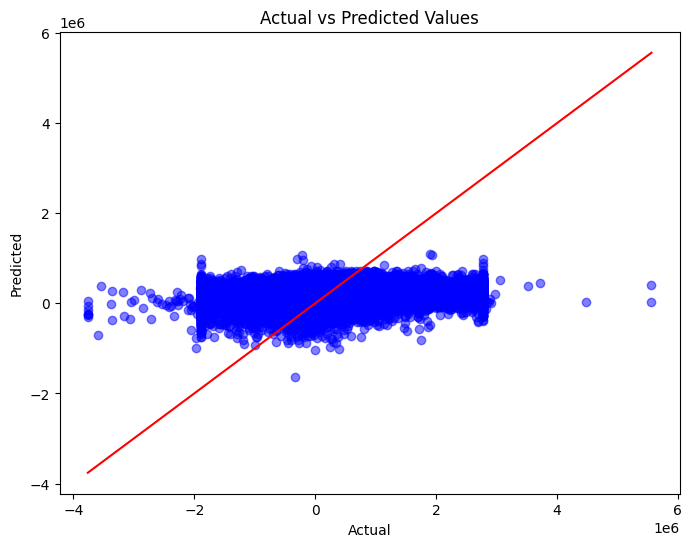

In [210]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### **🔹 Linear Regression: State, Year, Penalty Type, Fine Amount, Net Income**

In [219]:
# Adjusting the merge to differentiate YEAR columns from each DataFrame
merged_df = pd.merge(df_COSTclean[['PROVNUM', 'NET_INCOME', 'STATE_CODE', 'YEAR']].rename(columns={'YEAR': 'COST_YEAR'}),
                     df_PENALTYclean[['PROVNUM', 'PNLTY_TYPE', 'FINE_AMT', 'YEAR']].rename(columns={'YEAR': 'PENALTY_YEAR'}),
                     on='PROVNUM',how='left')

In [225]:
from sklearn.compose import ColumnTransformer

merged_df = pd.merge(df_COSTclean[['PROVNUM', 'NET_INCOME', 'STATE_CODE',]],
                     df_PENALTYclean[['PROVNUM', 'PNLTY_TYPE', 'FINE_AMT', 'YEAR']],
                     on='PROVNUM',
                     how='left')

merged_df['FINE_AMT_YEAR_INTERACTION'] = merged_df['FINE_AMT'] * merged_df['YEAR']

X = merged_df[['PNLTY_TYPE', 'STATE_CODE', 'YEAR', 'FINE_AMT', 'FINE_AMT_YEAR_INTERACTION']]
y = merged_df['NET_INCOME']

numeric_features = ['FINE_AMT', 'FINE_AMT_YEAR_INTERACTION']
categorical_features = ['PNLTY_TYPE', 'STATE_CODE', 'YEAR']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print(f'R^2 Score: {r2}')

Mean Squared Error: 1051306878504.941
R^2 Score: 0.0004369947887249426


### **🔹 Decision Tree: State, Year, Penalty Type, Fine Amount, Net Income**

In [226]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[('preprocessor', preprocessor),
 ('regressor', DecisionTreeRegressor(random_state=42))])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error with Decision Tree:", mse)
print(f'R^2 Score with Decision Tree: {r2}')


Mean Squared Error with Decision Tree: 919214537041.7646
R^2 Score with Decision Tree: 0.12602793355067066


### **🔹 Linear Regression: State, Penalty Type, Fine Amount,Rural vs. Urban, Net Income**

In [215]:
# Merge the dataframes
mergedPenalty_df = pd.merge(df_COSTclean, df_PENALTYclean, on='PROVNUM', how='left')

X = mergedPenalty_df[['PNLTY_TYPE', 'FINE_AMT', 'RURAL_VERSUS_URBAN', 'STATE_CODE']]
y = mergedPenalty_df['NET_INCOME']

X_encoded = pd.get_dummies(X, columns=['PNLTY_TYPE', 'RURAL_VERSUS_URBAN', 'STATE_CODE'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = LinearRegression()
model.fit(X_train_imputed, y_train)

y_pred = model.predict(X_test_imputed)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print(f'R^2 Score: {r2}')


Mean Squared Error: 917056694236.8853
R^2 Score: 0.1280795703114671


### **🔹 Random Forest: State, Penalty Type, Fine Amount,Rural vs. Urban, Net Income**

In [216]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

imputer = SimpleImputer(strategy='mean')

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = make_pipeline(imputer, rf_model)

pipeline.fit(X_train, y_train)

y_pred_rf = pipeline.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print(f'Random Forest R^2 Score: {r2_rf}')

Random Forest Mean Squared Error: 774285438634.1649
Random Forest R^2 Score: 0.2638238218006116


In [230]:
!jupyter nbconvert --to html BANA620_Analysis_CLEANED.ipynb

[NbConvertApp] Converting notebook BANA620_Analysis_CLEANED.ipynb to html
[NbConvertApp] Writing 3342393 bytes to BANA620_Analysis_CLEANED.html
